# DenoiSeg Example: DSB 2018
This is an example notebook which illustrates how DenoiSeg should be trained. In this notebook we use a refined version of the Kaggle 2018 Data Science Bowl (DSB 2018) dataset. We already split the data into train and test images. From the train images we then extracted 3800 training and 670 validation patches of size 128x128. The test set contains 50 images. 


In [1]:
# Here we are just importing some libraries which are needed to run this notebook.
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage

from denoiseg.models import DenoiSeg, DenoiSegConfig
from denoiseg.utils.misc_utils import combine_train_test_data, shuffle_train_data, augment_data
from denoiseg.utils.seg_utils import *
from denoiseg.utils.compute_precision_threshold import measure_precision

from csbdeep.utils import plot_history

import urllib
import os
import zipfile

Using TensorFlow backend.


## Downloading and  Data Loading
We created three versions of this dataset by adding Gaussian noise with zero mean and standard deviations 10 and 20. The dataset are marked with the suffixes n0, n10 and n20 accordingly.

In the next cell you can choose which `noise_level` you would like to investigate.

In [2]:
# Choose the noise level you would like to look at:
# Values: 'n0', 'n10', 'n20'
noise_level = 'n10'

In [3]:
# create a folder for our data
if not os.path.isdir('./data'):
    os.mkdir('data')
    
if noise_level == 'n0':
    link = 'https://owncloud.mpi-cbg.de/index.php/s/1WXxLSqbK0ZIxF5/download'
elif noise_level == 'n10':
    link = 'https://owncloud.mpi-cbg.de/index.php/s/dRc1AHcaH8mqeh7/download'
elif noise_level == 'n20':
    link = 'https://owncloud.mpi-cbg.de/index.php/s/hy6xSq82kCoqqSH/download'
else:
    print('This noise level does not exist for this dataset.')

# check if data has been downloaded already
zipPath="data/DSB2018_{}.zip".format(noise_level)
if not os.path.exists(zipPath):
    #download and unzip data
    data = urllib.request.urlretrieve(link, zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("data")

In [4]:
# Loading of the training images
trainval_data =  np.load('data/DSB2018_{}/train/train_data.npz'.format(noise_level))
train_images = trainval_data['X_train'].astype(np.float32)
train_masks = trainval_data['Y_train']
val_images = trainval_data['X_val'].astype(np.float32)
val_masks = trainval_data['Y_val']

In [5]:
print("Shape of train_images: {}".format(train_images.shape))
print("Shape of train_masks:  {}".format(train_masks.shape))
print("Shape of val_images:   {}".format(val_images.shape))
print("Shape of val_masks:    {}".format(val_masks.shape))

Shape of train_images: (3800, 128, 128)
Shape of train_masks:  (3800, 128, 128)
Shape of val_images:   (670, 128, 128)
Shape of val_masks:    (670, 128, 128)


## Small Amounts of Annotated Training Data
With DenoiSeg we present a solution to train deep neural networks if only few annotated ground truth segmentations are available. We simulate such a scenary by zeroing out all but a fraction of the available training data. In the next cell you can specify the percentage of training images for which ground truth annotations are available.

In [6]:
# Set the percentage of annotated training images.
# Values: 0.0 (no annotated images) to 100.0 (all images get annotations)
percentage_of_annotated_training_images = 0.5
assert percentage_of_annotated_training_images >= 0.0 and percentage_of_annotated_training_images <=100.0

In [7]:
# Seed to shuffle training data (annotated GT and raw image pairs).
seed = 1 

# First we shuffle the training images to remove any bias.
X_shuffled, Y_shuffled = shuffle_train_data(train_images, train_masks, random_seed=seed)
# Here we zero out all training images which are not part of the 
# selected percentage.
X_frac, Y_frac = zero_out_train_data(X_shuffled, Y_shuffled, fraction = percentage_of_annotated_training_images)

# Now we apply data augmentation to the training patches:
# Rotate four times by 90 degree and add flipped versions.
X, Y_train_masks = augment_data(X_frac, Y_frac)
X_val, Y_val_masks = val_images, val_masks

# Here we add the channel dimension to our input images.
# Dimensionality for training has to be 'SYXC' (Sample, Y-Dimension, X-Dimension, Channel)
X = X[...,np.newaxis]
Y = convert_to_oneHot(Y_train_masks)
X_val = X_val[...,np.newaxis]
Y_val = convert_to_oneHot(Y_val_masks)
print("Shape of X:     {}".format(X.shape))
print("Shape of Y:     {}".format(Y.shape))
print("Shape of X_val: {}".format(X_val.shape))
print("Shape of Y_val: {}".format(Y_val.shape))

Raw image size after augmentation (30400, 128, 128)
Mask size after augmentation (30400, 128, 128)
Shape of X:     (30400, 128, 128, 1)
Shape of Y:     (30400, 128, 128, 3)
Shape of X_val: (670, 128, 128, 1)
Shape of Y_val: (670, 128, 128, 3)


Next we look at a single sample. In the first column we show the input image, in the second column the background segmentation, in the third column the foreground segmentation and in the last column the border segmentation.

With the parameter `sample` you can choose different training patches. You will notice that not all of them have a segmentation ground truth.

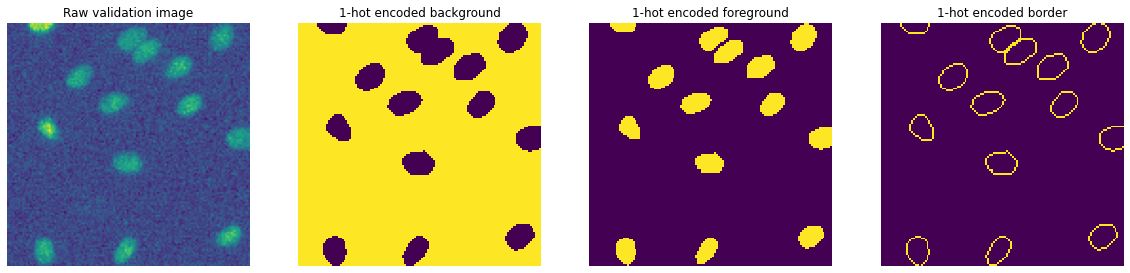

In [8]:
sample = 0
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.imshow(X[sample,...,0])
plt.axis('off')
plt.title('Raw validation image')
plt.subplot(1,4,2)
plt.imshow(Y[sample,...,0], vmin=0, vmax=1, interpolation='nearest')
plt.axis('off')
plt.title('1-hot encoded background')
plt.subplot(1,4,3)
plt.imshow(Y[sample,...,1], vmin=0, vmax=1, interpolation='nearest')
plt.axis('off')
plt.title('1-hot encoded foreground')
plt.subplot(1,4,4)
plt.imshow(Y[sample,...,2], vmin=0, vmax=1, interpolation='nearest')
plt.axis('off')
plt.title('1-hot encoded border');

### Configure network parameters

In [9]:
train_batch_size = 128
train_steps_per_epoch = max(100, min(int(X.shape[0]/train_batch_size), 400))

In the next cell, you can choose how much relative importance (weight) to assign to denoising 
and segmentation tasks by choosing appropriate value for `denoiseg_alpha` (between `0` and `1`; with `0` being
only segmentation and `1` being only denoising. Here we choose `denoiseg_alpha = 0.5`)

In [10]:
conf = DenoiSegConfig(X, unet_kern_size=3, n_channel_out=4, relative_weights = [1.0,1.0,5.0],
                      train_steps_per_epoch=train_steps_per_epoch, train_epochs=200, 
                      batch_norm=True, train_batch_size=128, unet_n_first = 32, 
                      unet_n_depth=4, denoiseg_alpha=0.5, train_tensorboard=True)

vars(conf)

{'means': ['13.494209'],
 'stds': ['20.886541'],
 'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 4,
 'train_loss': 'denoiseg',
 'unet_n_depth': 4,
 'relative_weights': [1.0, 1.0, 5.0],
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'probabilistic': False,
 'unet_residual': False,
 'unet_input_shape': (None, None, 1),
 'train_epochs': 200,
 'train_steps_per_epoch': 237,
 'train_learning_rate': 0.0004,
 'train_batch_size': 128,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'train_reduce_lr': {'monitor': 'val_loss', 'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 1.5,
 'n2v_patch_shape': (64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'denoiseg_alpha': 0.5}

In [11]:
model_name = 'DenoiSeg_DSB18_n10'
basedir = 'models'
model = DenoiSeg(conf, model_name, basedir)

/home/tbuchhol/Gitrepos/DenoiSeg/denoiseg/models/denoiseg_standard.py:533: UserWarning: output path for model already exists, files may be overwritten: /home/tbuchhol/Gitrepos/DenoiSeg/examples/DenoiSeg_2D/models/DenoiSeg_DSB18_n10
  'output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


In [12]:
history = model.train(X, Y, (X_val, Y_val))

/home/tbuchhol/Gitrepos/DenoiSeg/denoiseg/models/denoiseg_standard.py:144: UserWarning: small number of validation images (only 2.15642% of all images)
  warnings.warn("small number of validation images (only %.05f%% of all images)" % (100 * frac_val))
Preparing validation data:   0%|          | 0/670 [00:00<?, ?it/s]

61 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 670/670 [00:10<00:00, 63.22it/s]




Epoch 1/200
237/237 [==============================] - 144s 606ms/step - loss: 0.1425 - denoiseg: 0.1425 - seg_loss: 0.0036 - denoise_loss: 0.1389 - val_loss: 0.6639 - val_denoiseg: 0.6639 - val_seg_loss: 0.5376 - val_denoise_loss: 0.1263

Epoch 2/200
237/237 [==============================] - 132s 559ms/step - loss: 0.1280 - denoiseg: 0.1280 - seg_loss: 0.0023 - denoise_loss: 0.1257 - val_loss: 0.5660 - val_denoiseg: 0.5660 - val_seg_loss: 0.4311 - val_denoise_loss: 0.1349
Epoch 3/200
237/237 [==============================] - 132s 557ms/step - loss: 0.1254 - denoiseg: 0.1254 - seg_loss: 0.0015 - denoise_loss: 0.1238 - val_loss: 0.4611 - val_denoiseg: 0.4611 - val_seg_loss: 0.3407 - val_denoise_loss: 0.1204
Epoch 4/200
237/237 [==============================] - 132s 557ms/step - loss: 0.1249 - denoiseg: 0.1249 - seg_loss: 0.0012 - denoise_loss: 0.1237 - val_loss: 0.3975 - val_denoiseg: 0.3975 - val_seg_loss: 0.2764 - val_denoise_loss: 0.1211
Epoch 5/200
237/237 [====================

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151839). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 117s 492ms/step - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.7857e-04 - denoise_loss: 0.1196 - val_loss: 0.2489 - val_denoiseg: 0.2489 - val_seg_loss: 0.1278 - val_denoise_loss: 0.1211
Epoch 21/200
237/237 [==============================] - 115s 483ms/step - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.1923e-04 - denoise_loss: 0.1196 - val_loss: 0.2458 - val_denoiseg: 0.2458 - val_seg_loss: 0.1272 - val_denoise_loss: 0.1186
Epoch 22/200
 31/237 [==>...........................] - ETA: 1:40 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.6089e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131538). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 116s 489ms/step - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.5026e-04 - denoise_loss: 0.1196 - val_loss: 0.2621 - val_denoiseg: 0.2621 - val_seg_loss: 0.1436 - val_denoise_loss: 0.1186
Epoch 23/200
237/237 [==============================] - 115s 485ms/step - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.8389e-04 - denoise_loss: 0.1197 - val_loss: 0.2432 - val_denoiseg: 0.2432 - val_seg_loss: 0.1249 - val_denoise_loss: 0.1184
Epoch 24/200
 51/237 [=====>........................] - ETA: 1:32 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.0715e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145385). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:18 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.2861e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136563). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:17 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.4535e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161985). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 112s 472ms/step - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.4081e-04 - denoise_loss: 0.1197 - val_loss: 0.2465 - val_denoiseg: 0.2465 - val_seg_loss: 0.1278 - val_denoise_loss: 0.1187
Epoch 25/200
237/237 [==============================] - 107s 450ms/step - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 3.8713e-04 - denoise_loss: 0.1199 - val_loss: 0.2431 - val_denoiseg: 0.2431 - val_seg_loss: 0.1239 - val_denoise_loss: 0.1192
Epoch 26/200
 41/237 [====>.........................] - ETA: 1:26 - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 6.8268e-04 - denoise_loss: 0.1199

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174429). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:25 - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 6.6643e-04 - denoise_loss: 0.1198

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196012). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:23 - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 6.0256e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178543). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:08 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 5.0008e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164093). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 106s 446ms/step - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.4773e-04 - denoise_loss: 0.1194 - val_loss: 0.2442 - val_denoiseg: 0.2442 - val_seg_loss: 0.1244 - val_denoise_loss: 0.1199
Epoch 27/200
 34/237 [===>..........................] - ETA: 1:27 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.0990e-04 - denoise_loss: 0.1194 ETA: 37s - loss: 0.1206 - denoiseg

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184869). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200248). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:26 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.1459e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215094). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:26 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.0608e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234045). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243446). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:25 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.3987e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260917). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:23 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.4374e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255343). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:22 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.3364e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252772). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236683). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:21 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.1974e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249228). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:20 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.2999e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229451). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199279). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:21 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.2352e-04 - denoise_loss: 0.11 - ETA: 1:19 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.1729e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167469). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:10 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.0889e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135314). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:10 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.1904e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141785). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:10 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.1366e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187178). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 1:09 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.0998e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247857). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:09 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.0486e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262355). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 1:07 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.8953e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.272316). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 1:05 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.2011e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240182). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224868). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 1:04 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.1447e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216831). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 1:03 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.0997e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222802). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 1:02 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.2363e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218882). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 1:01 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.3206e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203125). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 1:00 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.2546e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158449). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 110s 466ms/step - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.1299e-04 - denoise_loss: 0.1196 - val_loss: 0.2598 - val_denoiseg: 0.2598 - val_seg_loss: 0.1372 - val_denoise_loss: 0.1226
Epoch 28/200
 37/237 [===>..........................] - ETA: 1:24 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.2106e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179720). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:23 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.5837e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236357). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:23 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.9688e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185821). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:23 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.8696e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235244). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:22 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.7752e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227608). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:21 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.6691e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220841). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:21 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.4239e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207133). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:20 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.2315e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166050). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:19 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.1577e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147744). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:13 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.7176e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196782). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:11 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.4182e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161359). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 48s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.1373e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137043). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 105s 444ms/step - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.9482e-04 - denoise_loss: 0.1194 - val_loss: 0.2511 - val_denoiseg: 0.2511 - val_seg_loss: 0.1308 - val_denoise_loss: 0.1203
Epoch 29/200
 15/237 [>.............................] - ETA: 1:19 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.1258e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133822). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:20 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 2.5203e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153311). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:28 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.2547e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138601). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:27 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.8146e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201378). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:27 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.8073e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227323). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:26 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.5957e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197114). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:24 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.3531e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226794). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202069). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:23 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.4265e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219069). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:22 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.2303e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198600). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:21 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.1642e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209977). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:20 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.0324e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217968). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:19 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.8937e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212345). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:18 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.2111e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210772). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:18 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.1516e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214003). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:17 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.3879e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218764). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:16 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.3204e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222101). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220529). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:15 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.2079e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232895). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:13 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.0222e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219873). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:12 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.0586e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190104). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:12 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.0130e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201972). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:10 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.2843e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175871). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:09 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.1956e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193789). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:08 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.1141e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217530). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:07 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.0343e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219291). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:06 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.2910e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199262). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 1:03 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.1243e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182668). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 1:03 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.0888e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158014). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 1:02 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.0201e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138082). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128977). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 1:01 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 2.9545e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148909). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 54s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.6549e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133983). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 26s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.0293e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143023). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 24s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.9667e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167316). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 23s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.9229e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135668). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 19s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.8077e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201564). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 17s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.7503e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226136). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 17s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.7312e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268839). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232501). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 15s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.7417e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129651). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 101s 427ms/step - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.9382e-04 - denoise_loss: 0.1192 - val_loss: 0.2446 - val_denoiseg: 0.2446 - val_seg_loss: 0.1262 - val_denoise_loss: 0.1185
Epoch 30/200
 27/237 [==>...........................] - ETA: 1:19 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 8.6236e-05 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155538). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:22 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 1.7153e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189554). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:22 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 1.9388e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217301). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234381). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:21 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 1.9619e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259404). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:21 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 1.8028e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236293). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:20 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 1.7553e-04 - denoise_loss: 0.1198

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262484). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:20 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 1.9435e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240220). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:19 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 1.8510e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221922). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:19 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 1.8079e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213837). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:18 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 1.7668e-04 - denoise_loss: 0.1198

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209221). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:17 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 2.1543e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205528). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:17 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 2.0680e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199426). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148482). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:16 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 1.9494e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154584). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 1:05 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 2.5377e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148090). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 36s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.3459e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151326). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 35s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.3246e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153199). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 22s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.7973e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156430). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 102s 429ms/step - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.6407e-04 - denoise_loss: 0.1193 - val_loss: 0.3029 - val_denoiseg: 0.3029 - val_seg_loss: 0.1828 - val_denoise_loss: 0.1201
Epoch 31/200
 14/237 [>.............................] - ETA: 1:14 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.6541e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184315). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:23 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 5.4923e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196576). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158676). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:22 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 5.2106e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179030). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:22 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 5.6620e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208923). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:21 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 5.4934e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231246). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246971). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:20 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 5.6524e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241989). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:20 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 5.9926e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227438). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:19 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 5.7394e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226487). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:19 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 6.0841e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256764). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:17 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 6.0578e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197132). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:16 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 5.8292e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195003). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169550). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:15 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 5.9224e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159185). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:14 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 5.7682e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189560). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:13 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 5.6721e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208724). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:12 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 5.5471e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201749). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:11 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 5.3492e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235410). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:10 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 5.2694e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228435). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197126). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:09 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 5.3189e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220393). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248075). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:08 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 5.1880e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259704). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:08 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 5.1929e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.264614). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:08 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 5.1493e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263976). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 1:07 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.9550e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243498). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:07 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.8931e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231433). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 1:02 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.5755e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141242). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 1:02 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.8317e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157799). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 1:01 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.9559e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189897). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 1:00 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.8558e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 1:00 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.8077e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196278). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 59s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.7601e-04 - denoise_loss: 0.1193 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244075). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 58s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.6489e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214163). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 56s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.5520e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178404). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 55s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.7207e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167738). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 20s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.5084e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144238). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 19s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.4848e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172715). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 18s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.5222e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218035). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 17s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.4766e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153628). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 16s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.4316e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163459). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134094). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 106s 447ms/step - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.2313e-04 - denoise_loss: 0.1192 - val_loss: 0.2507 - val_denoiseg: 0.2507 - val_seg_loss: 0.1325 - val_denoise_loss: 0.1182
Epoch 32/200
 40/237 [====>.........................] - ETA: 1:20 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.1872e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200469). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:19 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.4966e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216353). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237588). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:18 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.5797e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236356). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:17 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.5505e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212776). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:16 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.6253e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206490). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:16 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.5346e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194583). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:15 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.3634e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216499). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:14 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.3755e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140847). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:14 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.2231e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151477). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:13 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.1100e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215044). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:12 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.9793e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194803). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:11 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.9204e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197049). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:10 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.8068e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193173). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:07 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.8566e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136591). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 35s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.1160e-04 - denoise_loss: 0.1191  ETA: 1:02 - loss: 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156849). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 35s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.0991e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210168). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 34s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.0588e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210411). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 33s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.1496e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245647). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 32s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.1454e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219641). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184162). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 31s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.1679e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182711). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 30s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.4036e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185405). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 29s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.3505e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155280). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 27s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.2182e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144099). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 26s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.2418e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141827). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 25s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.1936e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156381). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156565). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 24s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.1597e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154293). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 23s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.0908e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144225). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 20s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.3558e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161992). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 19s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.3160e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192468). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 18s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.3837e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212485). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236533). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 17s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.3386e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203379). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 17s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.3422e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177349). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 16s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.3034e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159244). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 16s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.3610e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143887). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 15s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.3436e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147859). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 11s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.3758e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158937). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 10s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.4063e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185904). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174397). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 10s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.3856e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193373). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.2968e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212998). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201491). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 6s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.2313e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221700). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 5s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.3441e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226151). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.3503e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222666). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.3313e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226533). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.3126e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178808). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.3038e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230140). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.2855e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250272). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 100s 423ms/step - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.2675e-04 - denoise_loss: 0.1194 - val_loss: 0.2512 - val_denoiseg: 0.2512 - val_seg_loss: 0.1291 - val_denoise_loss: 0.1221
Epoch 33/200
  2/237 [..............................] - ETA: 55s - loss: 0.1219 - denoiseg: 0.1219 - seg_loss: 9.5010e-04 - denoise_loss: 0.1210

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177110). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228772). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:09 - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 7.6227e-04 - denoise_loss: 0.1205

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.280435). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  4/237 [..............................] - ETA: 1:16 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 5.7329e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.278705). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 1:22 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.8219e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.276975). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:24 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.2759e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.264670). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  8/237 [>.............................] - ETA: 1:25 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 2.8665e-04 - denoise_loss: 0.1199

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260277). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256321). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 10/237 [>.............................] - ETA: 1:18 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 2.2932e-04 - denoise_loss: 0.1200

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252365). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 11/237 [>.............................] - ETA: 1:18 - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 2.0847e-04 - denoise_loss: 0.1203

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225869). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/237 [>.............................] - ETA: 1:14 - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 2.0225e-04 - denoise_loss: 0.1202

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182708). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:15 - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 1.9004e-04 - denoise_loss: 0.1201

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180822). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:16 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 1.7817e-04 - denoise_loss: 0.1199

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197486). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:18 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 1.5004e-04 - denoise_loss: 0.1198

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199546). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:14 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 2.1621e-04 - denoise_loss: 0.1198

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197659). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:15 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 1.9741e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159239). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/237 [==>...........................] - ETA: 1:16 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 2.3043e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153608). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:20 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.1147e-04 - denoise_loss: 0.1196 ETA: 1:21 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.3817e-04 - denoise_loss: 0. - ETA: 1:21 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.1989e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164960). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134693). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:19 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.3768e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181036). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219061). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:18 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.3589e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238656). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:17 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.0755e-04 - denoise_loss: 0.1198

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223961). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:17 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 3.9888e-04 - denoise_loss: 0.1198

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230830). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:16 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.8292e-04 - denoise_loss: 0.1198

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245278). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:15 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.1141e-04 - denoise_loss: 0.1198

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214851). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:14 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.4029e-04 - denoise_loss: 0.1197 ETA: 1:14 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 3.9617e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224986). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220943). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:13 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.3243e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204252). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:12 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.5773e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195911). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:10 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.3593e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164068). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:10 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.5936e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131363). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 38s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.2131e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212878). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 37s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.1688e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253636). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 36s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.3167e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150324). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 2s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.4759e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146999). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.4189e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156749). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 97s 411ms/step - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.4170e-04 - denoise_loss: 0.1195 - val_loss: 0.2456 - val_denoiseg: 0.2456 - val_seg_loss: 0.1267 - val_denoise_loss: 0.1188
Epoch 34/200
 59/237 [======>.......................] - ETA: 1:09 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 5.2425e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173735). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:07 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 5.0706e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119012). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 54s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.9679e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161432). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176339). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 53s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.8705e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244520). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 52s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.7955e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255277). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 51s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.6814e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214279). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 51s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.6801e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165416). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 17s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.4445e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191560). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 16s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.4371e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221864). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177189). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 15s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.4457e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151219). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 14s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.4235e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168652). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.3264e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182208). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.3437e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252021). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.3150e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212353). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.2953e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255901). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211558). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 5s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.4191e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208348). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.3993e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197123). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.4316e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193823). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.4119e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157840). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 96s 405ms/step - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.3319e-04 - denoise_loss: 0.1192 - val_loss: 0.2580 - val_denoiseg: 0.2580 - val_seg_loss: 0.1390 - val_denoise_loss: 0.1190
Epoch 35/200
 16/237 [=>............................] - ETA: 1:13 - loss: 0.1207 - denoiseg: 0.1207 - seg_loss: 3.7103e-04 - denoise_loss: 0.1203

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156866). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:14 - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 3.2981e-04 - denoise_loss: 0.1200

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152327). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:15 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 2.8275e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173542). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:15 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.1403e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182435). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:13 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.1989e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184999). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:13 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.1374e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189516). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:11 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.0535e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195641). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201394). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:10 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.0902e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196877). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:09 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.0387e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211786). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:09 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.0638e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215901). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:09 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.4613e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208781). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:07 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.7418e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180225). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:07 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.6851e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204708). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:06 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.4745e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201614). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:05 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.4810e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185133). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:04 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.4333e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209617). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:04 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.3869e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204230). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:02 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.3434e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206383). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 1:01 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.3066e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215317). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230620). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 1:00 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.3002e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238385). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 1:00 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.2609e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231876). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 59s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.3183e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215176). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198077). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 57s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.1725e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161338). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 55s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.1796e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176229). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 54s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.2344e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179747). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 54s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.1836e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180631). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 51s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.0601e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143939). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 49s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.1955e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157261). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 49s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.1384e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173734). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184286). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 48s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.1148e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193005). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 46s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.1451e-04 - denoise_loss: 0.1198

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190430). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 44s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.1791e-04 - denoise_loss: 0.1198

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180227). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 43s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.1282e-04 - denoise_loss: 0.1198

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182432). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 43s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.1034e-04 - denoise_loss: 0.1198

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193446). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 41s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.0163e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179397). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 41s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.0235e-04 - denoise_loss: 0.1198

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195481). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217141). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 39s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.2967e-04 - denoise_loss: 0.1198

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175612). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 38s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.2842e-04 - denoise_loss: 0.1198

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186458). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 38s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.2606e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200681). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217865). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 37s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.1917e-04 - denoise_loss: 0.1198

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214185). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 36s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.2317e-04 - denoise_loss: 0.1198

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233078). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 35s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.2839e-04 - denoise_loss: 0.1198

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215894). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 35s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.2616e-04 - denoise_loss: 0.1198

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172088). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 32s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.1315e-04 - denoise_loss: 0.1198

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154257). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148501). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 32s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.1415e-04 - denoise_loss: 0.1198

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195118). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 32s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.1475e-04 - denoise_loss: 0.1198

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222234). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249347). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 31s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.2668e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249810). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 30s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.3470e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248827). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.278774). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 29s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.4255e-04 - denoise_loss: 0.1198

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266414). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 22s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.2791e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145944). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 20s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.3694e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204003). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 19s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.4836e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212683). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 18s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.4472e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182267). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 6s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.4796e-04 - denoise_loss: 0.1198

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151083). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.4588e-04 - denoise_loss: 0.1198

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153086). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.4434e-04 - denoise_loss: 0.1198

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136277). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.5544e-04 - denoise_loss: 0.1198

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203273). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140806). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.6354e-04 - denoise_loss: 0.1198

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140431). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.6199e-04 - denoise_loss: 0.1198

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156868). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.6454e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159324). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156364). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 99s 418ms/step - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.6300e-04 - denoise_loss: 0.1197 - val_loss: 0.2399 - val_denoiseg: 0.2399 - val_seg_loss: 0.1213 - val_denoise_loss: 0.1187
Epoch 36/200
  2/237 [..............................] - ETA: 1:12 - loss: 0.1210 - denoiseg: 0.1210 - seg_loss: 8.0406e-04 - denoise_loss: 0.1202

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.304463). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:19 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 5.3604e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223604). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142744). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 1:15 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 8.6098e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159505). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151125). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 10/237 [>.............................] - ETA: 1:10 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 6.0022e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213622). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/237 [>.............................] - ETA: 1:10 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 5.3018e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174304). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:13 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 6.2170e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228421). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:14 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 5.8025e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181787). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183135). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:14 - loss: 0.1207 - denoiseg: 0.1207 - seg_loss: 5.7926e-04 - denoise_loss: 0.1201

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175817). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:12 - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 5.5721e-04 - denoise_loss: 0.1201

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169296). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:12 - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 5.4432e-04 - denoise_loss: 0.1200

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160234). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155034). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:10 - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 6.0786e-04 - denoise_loss: 0.1200

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152954). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:10 - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 5.8721e-04 - denoise_loss: 0.1199

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149452). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:14 - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 4.1738e-04 - denoise_loss: 0.12

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196969). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:13 - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 4.0720e-04 - denoise_loss: 0.1202

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201616). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:13 - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 3.8826e-04 - denoise_loss: 0.1202

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206420). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:11 - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 3.9119e-04 - denoise_loss: 0.1202

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180264). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:09 - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 3.9037e-04 - denoise_loss: 0.1200

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176062). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:08 - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 3.9038e-04 - denoise_loss: 0.1200

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189875). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:07 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 3.8355e-04 - denoise_loss: 0.1198

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176328). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:05 - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 3.7725e-04 - denoise_loss: 0.1199

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171498). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:05 - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 3.9834e-04 - denoise_loss: 0.1199

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 56s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.3149e-04 - denoise_loss: 0.1198

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179836). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 54s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.2503e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201332). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 53s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.5563e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239234). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197379). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 52s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.7940e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146384). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 51s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.6096e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239788). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 51s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.5657e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232515). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 49s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.6418e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224561). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 49s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.5918e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233654). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 47s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.9436e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214319). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 47s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.9010e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218841). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 46s - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 4.8189e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182493). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.2543e-04 - denoise_loss: 0.1194 - ETA: 15s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.9952e-04 - denoise - ETA: 10s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.0358e-04 - denoi

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133641). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.2703e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165573). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.3216e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199455). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134973). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.2737e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229268). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.2821e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154417). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164786). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 96s 405ms/step - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.2638e-04 - denoise_loss: 0.1194 - val_loss: 0.2437 - val_denoiseg: 0.2437 - val_seg_loss: 0.1234 - val_denoise_loss: 0.1202
Epoch 37/200
 16/237 [=>............................] - ETA: 1:10 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.4103e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177472). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:11 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.2685e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225057). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:11 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.0317e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230265). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:12 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 1.8382e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198415). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170071). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:12 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 1.6784e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149127). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:12 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.5154e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177978). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:12 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.4051e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183767). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:11 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.0945e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136606). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:04 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 2.9425e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165650). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195213). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:03 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 2.8885e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209054). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 1:01 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.1960e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177986). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 1:00 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.2676e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210945). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 59s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.2283e-04 - denoise_loss: 0.1194 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223482). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157752). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 59s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.1898e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208517). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/237 [=========>....................] - ETA: 59s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.4104e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226292). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 58s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.3708e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225512). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 58s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.3320e-04 - denoise_loss: 0.119

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237463). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239252). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 56s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.4399e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238472). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 56s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.4025e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228844). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 55s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.3301e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236574). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 55s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.2951e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228735). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 53s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.2835e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188648). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 52s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.2756e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208422). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 52s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.2438e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212905). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176064). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 51s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.2126e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187864). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 50s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.2833e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180256). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 49s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.4492e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181571). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 48s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.9141e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179892). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 47s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.8461e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180258). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 46s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.7760e-04 - denoise_loss: 0.1192- ETA: 46s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.7974e-04 - denoise_loss: 0.119

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195170). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179061). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 45s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.7251e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169469). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 45s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.6943e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170301). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 44s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.9849e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184268). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 43s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.9336e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148613). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 39s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.7627e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168055). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 38s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.7081e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148095). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 37s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.8588e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181684). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145105). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 28s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.7401e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156816). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 26s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.8658e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168660). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 23s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.7871e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199036). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 23s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.7657e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213009). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 21s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.7403e-04 - denoise_loss: 0.1191- ETA: 22s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.7611e-04 - denoise_loss: 0.119

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177656). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204792). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 20s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.8637e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185465). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 19s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.8177e-04 - denoise_loss: 0.119 - ETA: 18s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.7975e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184437). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 17s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.8467e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178964). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 16s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.8304e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138161). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 15s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.7915e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154920). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 395ms/step - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.8598e-04 - denoise_loss: 0.1192 - val_loss: 0.2406 - val_denoiseg: 0.2406 - val_seg_loss: 0.1222 - val_denoise_loss: 0.1184
Epoch 38/200
  4/237 [..............................] - ETA: 52s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 6.1817e-05 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139420). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:12 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.2843e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147310). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:06 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.8238e-04 - denoise_loss: 0.1190 ETA: 1:07 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.8256e-04 - denoise_loss

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175324). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:05 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.9686e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175766). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:04 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.9249e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190604). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:04 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.8821e-04 - denoise_loss: 0.11 - ETA: 1:03 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.8415e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200754). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:01 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.8574e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203706). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 59s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.7523e-04 - denoise_loss: 0.1189 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189527). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 59s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.9902e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179655). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 58s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.0156e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185953). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 58s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.1455e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200232). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 57s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.2517e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178643). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 55s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.2952e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193388). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 55s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.2601e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190486). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206855). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 52s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.3473e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213333). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226631). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 52s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.5784e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237980). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 51s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.5437e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233396). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 50s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.4791e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236004). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 50s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.4151e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234715). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 49s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.3528e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235644). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 48s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.4206e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233036). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219881). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 47s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.5333e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221199). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201501). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 47s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.4730e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159101). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 45s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.9028e-04 - denoise_loss: 0.1191- ETA: 46s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.8153e-04 - denoise_loss: 0.11 - ETA: 45s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.8700e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212718). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 44s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.9244e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206174). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226526). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 43s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.8451e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236331). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 42s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.1388e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165366). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 41s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.2016e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212201). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 40s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.1379e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170288). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 37s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.0563e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148923). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 36s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.9718e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137717). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182655). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 35s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.9442e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205361). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 30s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.8681e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153667). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 30s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.1441e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196970). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 28s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.0749e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224141). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 28s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.0501e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200355). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 27s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.0030e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177466). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 21s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.1236e-04 - denoise_loss: 0.1192- ETA: 26s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.0149e-04 - denoise_l

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188653). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 20s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.0772e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163532). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169273). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 19s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.1972e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214422). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 18s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.1088e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214464). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.9792e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208378). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252937). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.0187e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.316033). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.9842e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177822). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.9503e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216202). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.274746). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 401ms/step - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.9490e-04 - denoise_loss: 0.1192 - val_loss: 0.2429 - val_denoiseg: 0.2429 - val_seg_loss: 0.1246 - val_denoise_loss: 0.1183
Epoch 39/200
  2/237 [..............................] - ETA: 1:11 - loss: 0.1228 - denoiseg: 0.1228 - seg_loss: 0.0000e+00 - denoise_loss: 0.1228

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.326819). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:22 - loss: 0.1226 - denoiseg: 0.1226 - seg_loss: 0.0000e+00 - denoise_loss: 0.12

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.320587). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.322807). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:32 - loss: 0.1209 - denoiseg: 0.1209 - seg_loss: 0.0000e+00 - denoise_loss: 0.1209

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.318581). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:33 - loss: 0.1207 - denoiseg: 0.1207 - seg_loss: 7.3951e-05 - denoise_loss: 0.1207

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.314355). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/237 [>.............................] - ETA: 1:32 - loss: 0.1207 - denoiseg: 0.1207 - seg_loss: 1.4606e-04 - denoise_loss: 0.1205

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.292318). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 10/237 [>.............................] - ETA: 1:31 - loss: 0.1207 - denoiseg: 0.1207 - seg_loss: 1.4794e-04 - denoise_loss: 0.1205

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.270280). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.264467). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/237 [>.............................] - ETA: 1:30 - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 1.3514e-04 - denoise_loss: 0.1204

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256560). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252703). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:26 - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 1.1584e-04 - denoise_loss: 0.1202

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227352). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190190). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:21 - loss: 0.1209 - denoiseg: 0.1209 - seg_loss: 2.8412e-04 - denoise_loss: 0.1206

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175014). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:21 - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 2.5276e-04 - denoise_loss: 0.1203

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188587). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:21 - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 2.4127e-04 - denoise_loss: 0.1204

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198823). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:20 - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 2.3078e-04 - denoise_loss: 0.1203

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183646). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:17 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 1.9659e-04 - denoise_loss: 0.1200

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217010). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179263). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:14 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 3.3658e-04 - denoise_loss: 0.1198

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173964). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:14 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.2668e-04 - denoise_loss: 0.1198

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237421). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:19 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 2.8528e-04 - denoise_loss: 0.1198

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228439). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205105). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235456). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:17 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 2.9543e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217038). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201314). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:13 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.4117e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207016). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:13 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.3461e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203807). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:12 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.2829e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218955). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:11 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.1071e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230964). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233253). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:11 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.3827e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233259). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:10 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.3188e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232985). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:08 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.3115e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184275). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215017). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:07 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.2605e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190577). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:06 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.2936e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184181). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:04 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.1328e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179843). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:03 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.2238e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180750). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:03 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.1814e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201586). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 1:01 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.2327e-04 - denoise_loss: 0.1194 ETA: 1:01 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.2278e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227251). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 1:00 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.1940e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215497). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 1:00 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.1555e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192926). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 1:00 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.3328e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186890). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 59s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.2553e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186992). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 58s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.2279e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197217). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 57s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.1916e-04 - denoise_loss: 0.119

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229040). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 56s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.1738e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230535). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 55s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.0736e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231791). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 54s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.0110e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230621). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 54s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.1914e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230083). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 53s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.2109e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229314). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 53s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.1828e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204095). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175809). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 51s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.0780e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204864). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 50s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 2.9925e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194102). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 49s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.0644e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220561). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 49s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.0366e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232121). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 48s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.0610e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232116). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 48s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.0512e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220545). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 47s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 2.9981e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199076). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183934). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 46s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 2.9305e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210635). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 45s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 2.9991e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153855). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 44s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 2.9259e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143446). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 43s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 2.9257e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178931). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 41s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 2.9661e-04 - denoise_loss: 0.1194- ETA: 41s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 2.8931e-04 - denoise_loss: 0.119

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205446). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 40s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.0556e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230619). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 39s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.0331e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223871). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187611). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 38s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.0052e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175599). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 36s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.1425e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211811). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 35s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.0789e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166421). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141922). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 22s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.2428e-04 - denoise_loss: 0.1194- ETA: 34s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.16

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152948). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 22s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.2553e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147979). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 395ms/step - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.4394e-04 - denoise_loss: 0.1194 - val_loss: 0.2590 - val_denoiseg: 0.2590 - val_seg_loss: 0.1396 - val_denoise_loss: 0.1194
Epoch 40/200
 24/237 [==>...........................] - ETA: 1:07 - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 1.5974e-04 - denoise_loss: 0.1204

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184602). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:07 - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 1.4784e-04 - denoise_loss: 0.1203

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202467). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:07 - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 2.5056e-04 - denoise_loss: 0.1201

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138917). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:09 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 2.7622e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186983). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:09 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 2.7125e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214212). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:08 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.3201e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235503). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:08 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.2608e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246575). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:07 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.4277e-04 - denoise_loss: 0.1194 ETA: 1:08 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.1484e-04 - denoise_loss: 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.273718). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:07 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.3162e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.270579). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:06 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.2652e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231461). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:05 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.6420e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224486). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208733). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:04 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.5894e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181562). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:03 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.5100e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128637). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:01 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.3360e-04 - denoise_loss: 0.1195 ETA: 1:02 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.3788e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164440). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 1:00 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.2128e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154832). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 57s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.3095e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145433). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 56s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.4357e-04 - denoise_loss: 0.119

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160088). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 55s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.3623e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174680). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192480). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200373). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 52s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.2768e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225832). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 51s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.2287e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172024). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 49s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.3561e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178626). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 48s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.2646e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163245). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 47s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.1779e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184532). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 47s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.1617e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208243). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 46s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.1780e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230061). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 45s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.1245e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210720). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 45s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.0724e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231602). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............]

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235750). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 44s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.4492e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238469). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236212). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 43s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.3936e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240808). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215330). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 42s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.3136e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204097). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227047). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 41s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.2868e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236366). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225785). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 41s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.2757e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185228). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 39s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.4248e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147129). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 37s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.3726e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144885). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 37s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.3248e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155348). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 36s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.2783e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187171). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 35s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.2784e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210290). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184313). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 34s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.3612e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192530). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 33s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.3387e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169412). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 33s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.3770e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143245). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 32s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.4587e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151279). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199691). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 30s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.4484e-04 - denoise_loss: 0.119

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228176). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 29s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.5819e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234614). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 28s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.5598e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218484). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 28s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.5628e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223549). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 26s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.4988e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213870). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 26s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.4779e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222205). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 24s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.5622e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205561). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 23s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.5355e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180315). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 22s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.4763e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136819). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 18s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.6789e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168354). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 17s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.6597e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212257). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 15s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.6548e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196714). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 14s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.7175e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204459). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179313). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 13s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.6901e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209609). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 13s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.6722e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231280). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 11s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.6613e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230009). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.6414e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231468). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 10s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.6803e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212578). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 9s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.7591e-04 - denoise_loss: 0.1194 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172861). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211207). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.7625e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175643). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.7757e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191248). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 6s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.8179e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140169). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.7056e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142872). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 92s 390ms/step - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.6998e-04 - denoise_loss: 0.1194 - val_loss: 0.2381 - val_denoiseg: 0.2381 - val_seg_loss: 0.1187 - val_denoise_loss: 0.1194
Epoch 41/200
 16/237 [=>............................] - ETA: 1:04 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.9670e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133297). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:05 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5262e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146569). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:07 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0978e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153087). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:07 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.9570e-04 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190877). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:07 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2689e-04 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145296). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/237 [==>...........................] - ETA: 1:07 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1327e-04 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134025). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:08 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7846e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137071). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 42s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.8792e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187168). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 42s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.8477e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207136). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 42s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8166e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230879). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 41s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.8060e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231809). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 40s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7443e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231225). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 39s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7300e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233173). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 38s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6752e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234550). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 38s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6208e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233218). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 36s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.5793e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233641). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 36s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.5537e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232668). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 35s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.5591e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228498). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 35s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.5327e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226525). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219858). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 33s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.4688e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219671). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144845). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 30s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6046e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148963). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 29s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6940e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193712). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 29s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6962e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182061). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 28s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6503e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191899). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 28s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7945e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185766). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 24s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6700e-04 - denoise_loss: 0.1189- ETA: 27s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7255e-04 - denoise_loss: 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189181). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 24s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6487e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185954). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 23s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.6380e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163131). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 22s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5563e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144374). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 20s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5158e-04 - denoise_loss: 0.1189- ETA: 20s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5351e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169329). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 19s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.4967e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198476). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 18s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.4406e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219785). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 16s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.4655e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223522). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226130). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 16s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.4396e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222392). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203362). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 15s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.4329e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188084). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 15s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.4415e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182854). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 14s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.4989e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167790). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 14s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.4813e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142541). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 91s 382ms/step - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5608e-04 - denoise_loss: 0.1190 - val_loss: 0.2433 - val_denoiseg: 0.2433 - val_seg_loss: 0.1251 - val_denoise_loss: 0.1182
Epoch 42/200
  5/237 [..............................] - ETA: 1:01 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.5308e-04 - denoise_loss: 0.1198

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144248). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 1:03 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 9.1912e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230393). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:02 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 5.2239e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157853). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:04 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.5662e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131549). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:04 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.3586e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180761). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:06 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 5.0007e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144408). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:06 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.8283e-04 - denoise_loss: 0.11 - ETA: 1:06 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.6704e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184166). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:06 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.6468e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198416). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:06 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.5555e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215730). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:06 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.4290e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201480). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:06 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.1959e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160169). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:05 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.5564e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140526). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:09 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 5.1574e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160791). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:08 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 5.3624e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194547). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:08 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 5.3810e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201507). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215376). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:07 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 5.2441e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218215). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:05 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.7918e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212592). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:04 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.8367e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221611). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221396). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:04 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 5.9412e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222988). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:02 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 6.1897e-04 - denoise_loss: 0.1189 ETA: 1:03 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 6.4799e-04 - denoise_loss: 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223633). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172997). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:00 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 6.3489e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214414). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:00 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 6.2607e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215536). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 59s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 6.4274e-04 - denoise_loss: 0.1189 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183472). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 58s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 6.6538e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184893). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 57s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 6.4373e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186067). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 57s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 6.3578e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163316). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 56s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 6.2684e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218678). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 52s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 5.5634e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157404). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 52s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 5.5048e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161480). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 52s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 5.4475e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185528). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 51s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 5.3913e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204346). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 50s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 5.2447e-04 - denoise_loss: 0.1190- ETA: 50s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 5.2878e-04 - denoise_loss: 0.119

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211023). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208653). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 50s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 5.1928e-04 - denoise_loss: 0.119

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216378). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 49s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 5.2723e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215717). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 49s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 5.3525e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203685). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 48s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 5.2515e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176294). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 47s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 5.1628e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168561). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 45s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 5.0160e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198191). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 43s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 5.1359e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228938). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194139). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 42s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 5.0100e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152138). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 41s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.9735e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137669). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 41s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 5.0107e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196705). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 40s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 5.0065e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173101). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 39s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.8776e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227497). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 38s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.8043e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194802). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 37s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.7348e-04 - denoise_loss: 0.119

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213251). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 37s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.7092e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185195). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 35s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.6257e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145724). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 28s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.3846e-04 - denoise_loss: 0.1192- ETA: 29s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.3665e-04 - denoise_loss: 0.119 - ETA: 28s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.3390e-04 - denoise_loss: 0.119

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172200). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208884). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 28s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.3573e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229568). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 27s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.2776e-04 - denoise_loss: 0.1192- ETA: 27s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.3039e-04 - denoise_loss: 0.119

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235092). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 26s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.2757e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232165). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232419). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 25s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.3245e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230518). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220086). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 24s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.3221e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159276). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 23s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.2630e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199190). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 23s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.2207e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208637). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 21s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.1498e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195716). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 21s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.1455e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203893). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 20s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.1293e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212398). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 19s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.1918e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200294). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176641). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 19s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.1692e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188103). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 18s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.1499e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196829). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 17s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.1315e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184763). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 16s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.0929e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171745). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 16s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.0951e-04 - denoise_loss: 0.119 - ETA: 15s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.0741e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201759). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 14s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.0667e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210047). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 13s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.0754e-04 - denoise_loss: 0.1192- ETA: 13s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.0450e-04 - denoise_loss: 0.119

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188742). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177557). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 12s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.1574e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179321). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 11s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.1907e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169376). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 10s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.1306e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154888). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 9s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.0914e-04 - denoise_loss: 0.1192 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209281). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 8s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.1545e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227097). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.1665e-04 - denoise_loss: 0.11 - ETA: 8s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.1471e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225231). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 7s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.1916e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227470). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 6s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.3250e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231332). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.3530e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233602). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 5s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.3307e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229466). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 4s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.2925e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234001). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.2734e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241854). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244373). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 3s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.2505e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237191). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 2s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.3345e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234079). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235265). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.3297e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226027). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.2926e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204223). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.2742e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185723). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 90s 381ms/step - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.2357e-04 - denoise_loss: 0.1193 - val_loss: 0.2377 - val_denoiseg: 0.2377 - val_seg_loss: 0.1195 - val_denoise_loss: 0.1182
Epoch 43/200
  4/237 [..............................] - ETA: 52s - loss: 0.1221 - denoiseg: 0.1221 - seg_loss: 8.4295e-04 - denoise_loss: 0.1212

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157378). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 1:06 - loss: 0.1208 - denoiseg: 0.1208 - seg_loss: 5.6325e-04 - denoise_loss: 0.1203

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239316). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154176). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:07 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.7869e-04 - denoise_loss: 0.1193 ETA: 1:05 - loss: 0.1195 - denoiseg: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163219). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:07 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.3055e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188581). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207887). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:06 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.2243e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217419). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:06 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.4045e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213368). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:05 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.1824e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209656). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:05 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.1488e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219188). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:05 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.0796e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232573). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:04 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.4852e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220173). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:04 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.5747e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216122). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:03 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.4340e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206711). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:03 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.4413e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182277). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144133). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:01 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.6154e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172659). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:00 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.5522e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205413). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:00 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.4868e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212817). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232042). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 59s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.4278e-04 - denoise_loss: 0.1192 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232138). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 58s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.3878e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223786). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204729). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 57s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.3006e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186364). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170698). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/237 [=========>....................] - ETA: 56s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.3396e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130741). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 40s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.9486e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165286). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 39s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.8878e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206489). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 39s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.8983e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217842). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 38s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.8954e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190048). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 37s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.8385e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199800). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 36s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.7999e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186073). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 35s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.8514e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181901). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191653). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 35s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.9873e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212236). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 34s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.0694e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213106). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234779). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 34s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.0415e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234641). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 33s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.9873e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224111). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 32s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.9345e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234012). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 31s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.8582e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225388). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 30s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.9054e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222970). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 30s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.8803e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222758). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219722). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 28s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.9583e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225064). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 28s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.1221e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227746). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 27s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.0716e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233514). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 27s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.0619e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237819). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 25s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.9812e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235437). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 25s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.9758e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233575). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 24s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.0564e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230510). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 24s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.0515e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229505). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202665). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 22s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.9824e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144792). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 21s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.0526e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143595). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 19s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.0546e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187197). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202789). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 19s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.0110e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224657). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 17s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.9347e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223764). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 16s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8940e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197726). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 15s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8341e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192068). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 14s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7968e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210929). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 14s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7932e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189949). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 13s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7554e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198065). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 13s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7369e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177229). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 10s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8151e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130199). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170537). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 9s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8404e-04 - denoise_loss: 0.1188 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145499). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 8s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8041e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182417). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.7339e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157906). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151810). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.7318e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143604). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.6734e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138158). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 1s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.7307e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200656). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 91s 382ms/step - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.7408e-04 - denoise_loss: 0.1190 - val_loss: 0.2399 - val_denoiseg: 0.2399 - val_seg_loss: 0.1214 - val_denoise_loss: 0.1185
Epoch 44/200
  2/237 [..............................] - ETA: 1:01 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 0.0012 - denoise_loss: 0.1172

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237353). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 59s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 5.7788e-04 - denoise_loss: 0.1187- ETA: 52s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 7.2235e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165415). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:04 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.0797e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146075). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:05 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.0961e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145349). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:06 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.0994e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225674). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:06 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.9887e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231257). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:06 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.8045e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232629). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:06 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.6105e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230603). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:06 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.5387e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231515). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:06 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.4682e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231974). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:07 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.4015e-04 - denoise_loss: 0.11 - ETA: 1:06 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.4359e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233275). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:06 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.5236e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232528). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:05 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.9546e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234575). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:06 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 2.7520e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172566). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:05 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.6721e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218163). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162338). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:05 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.6268e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177379). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:04 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.2486e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221866). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:04 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.1970e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179199). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:03 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.5551e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187921). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:03 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.5012e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177981). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:02 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.3982e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157502). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:01 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.2666e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201676). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:00 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.2907e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214280). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 59s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.3419e-04 - denoise_loss: 0.1193 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221826). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 58s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.4925e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221160). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 58s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.6430e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202793). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173588). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 56s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.5341e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161173). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 55s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.5889e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171140). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183555). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 54s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.5343e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207519). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199102). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 54s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.4876e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216007). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 53s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.4509e-04 - denoise_loss: 0.119 - ETA: 53s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.4142e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192043). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195227). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 51s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.3126e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188340). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166711). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 51s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.2784e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138554). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 50s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.3121e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153350). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 37s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.1905e-04 - denoise_loss: 0.1191- ETA: 42s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.9812e-04 - denoi

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159989). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 34s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.2062e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142569). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 90s 381ms/step - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.7400e-04 - denoise_loss: 0.1191 - val_loss: 0.2440 - val_denoiseg: 0.2440 - val_seg_loss: 0.1239 - val_denoise_loss: 0.1201
Epoch 45/200
 56/237 [======>.......................] - ETA: 1:05 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6738e-04 - denoise_loss: 0.1186 ETA: 1:05 - loss: 0.1189 - denoiseg: 0.1189 - seg_l

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187403). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201218). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:05 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7557e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212183). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:04 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6228e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216174). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:04 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6200e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220608). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:02 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7042e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206817). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:02 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6199e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210393). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:01 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.9810e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231289). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:00 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.3607e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225488). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 59s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.3749e-04 - denoise_loss: 0.1186 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224577). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 58s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.2809e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224441). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 58s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.2254e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196020). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 57s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.0669e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174424). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198238). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 56s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.9285e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202245). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/237 [=========>....................] - ETA: 55s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.0123e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201991). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 51s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.0575e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155018). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173304). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 50s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.0502e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189803). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 49s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.9713e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215063). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224401). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 48s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.9043e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225181). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 48s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.8886e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226143). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 47s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.9829e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228572). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 46s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.1246e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222190). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 45s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.0174e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202406). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 44s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.9468e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189318). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 43s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.9137e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159442). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 33s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.6107e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155650). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 31s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.5389e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156392). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 31s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5066e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158294). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189491). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 30s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.4838e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203842). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 30s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.5510e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223275). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 28s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.5776e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227483). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 28s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.5336e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228323). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207973). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 24s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5955e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158805). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 23s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5704e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185680). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 22s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.6036e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193655). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 21s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5802e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177481). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169506). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 18s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5235e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192557). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190222). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 17s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.4862e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215127). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 17s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.4681e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214149). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226379). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 17s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.4499e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227918). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 16s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5900e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226940). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 16s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5716e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229685). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 14s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.6271e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226021). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 14s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.6806e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223715). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 14s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.7517e-04 - denoise_loss: 0.119

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216437). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 12s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.7420e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196951). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 11s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.7407e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211783). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 10s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.7108e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215495). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 10s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.7820e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197887). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 90s 380ms/step - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5416e-04 - denoise_loss: 0.1190 - val_loss: 0.2423 - val_denoiseg: 0.2423 - val_seg_loss: 0.1219 - val_denoise_loss: 0.1204
Epoch 46/200
 18/237 [=>............................] - ETA: 1:05 - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 3.3237e-04 - denoise_loss: 0.1200

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166167). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:05 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 3.1487e-04 - denoise_loss: 0.1199

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213148). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:07 - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 5.8013e-04 - denoise_loss: 0.1200

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230534). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182792). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:07 - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 5.3165e-04 - denoise_loss: 0.1199

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230523). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:08 - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 4.9323e-04 - denoise_loss: 0.1200

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231164). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150249). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:07 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.4063e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191148). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:07 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.3369e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237885). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:06 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.0555e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248413). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:05 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 2.9656e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259440). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227106). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:05 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 2.9223e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257896). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:04 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.0955e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258974). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:04 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.0540e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260697). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.280500). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:03 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.2624e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.282818). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.281095). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 1:02 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.4467e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.305733). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:02 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.4036e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.302500). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 1:02 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.3628e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.303931). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/237 [=========>....................] - ETA: 1:01 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.4246e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241410). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 1:00 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.4387e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.270163). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 1:00 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.4503e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263142). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 59s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.4764e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.281765). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 58s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.9539e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258712). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 58s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.0897e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.277799). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 56s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.0765e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.276583). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 56s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.0619e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263903). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 55s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.0216e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.277048). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 54s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.1040e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266656). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 54s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.1752e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240437). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 53s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.0979e-04 - denoise_loss: 0.119 - ETA: 52s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.0603e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197662). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 51s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.9379e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183828). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 50s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.9034e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208303). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 49s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.9696e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249124). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 49s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.9363e-04 - denoise_loss: 0.119

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253347). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258199). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - ETA: 49s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.9032e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261353). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 48s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.8390e-04 - denoise_loss: 0.119 - ETA: 47s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.9656e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253458). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 46s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.0367e-04 - denoise_loss: 0.1194- ETA: 46s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.0689e-04 - denoise_loss: 0.119

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256086). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261867). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 46s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.0049e-04 - denoise_loss: 0.119 - ETA: 45s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.9736e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257126). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 44s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.0393e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252205). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257986). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 43s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.0540e-04 - denoise_loss: 0.1194- ETA: 44s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.0847e-04 - denoise_loss: 0.119

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249229). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 43s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.0238e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267185). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 42s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.9801e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250262). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 40s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.8772e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246425). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 40s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.8500e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.264381). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 40s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.8229e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257342). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 39s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.7913e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260898). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 38s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.7651e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251014). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 37s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.6888e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228355). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 35s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.7533e-04 - denoise_loss: 0.1194- ETA: 36s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.7516e-04 - denoise_loss: 0.119

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168499). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 34s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.7903e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213320). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245838). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 33s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.8283e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261589). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 32s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.8044e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259029). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 32s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.7919e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252460). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 31s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.8759e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247629). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 28s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.8293e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243148). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 26s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.9234e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241933). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242736). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 26s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.8789e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240083). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 24s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.9056e-04 - denoise_loss: 0.119

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243821). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 23s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.8627e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.270447). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242384). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 23s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.9973e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239808). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 21s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.9338e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248458). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 20s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.8596e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.272784). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.275887). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 19s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.8197e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255711). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 18s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.7999e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.277807). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 17s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.7824e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.272962). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 16s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.7976e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259297). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265218). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 15s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.8012e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253797). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245308). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 13s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.7457e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249478). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 12s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.7386e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227602). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207312). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 12s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.7142e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206760). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 11s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.6966e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213663). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 8s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.7223e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186473). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 8s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.7052e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221665). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165391). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.7342e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174730). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 3s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.7081e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231314). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.7484e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148348). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 103s 433ms/step - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.7328e-04 - denoise_loss: 0.1193 - val_loss: 0.2367 - val_denoiseg: 0.2367 - val_seg_loss: 0.1184 - val_denoise_loss: 0.1183
Epoch 47/200
  4/237 [..............................] - ETA: 1:16 - loss: 0.1212 - denoiseg: 0.1212 - seg_loss: 2.7457e-04 - denoise_loss: 0.1209

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241400). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244206). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 1:20 - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 2.0837e-04 - denoise_loss: 0.1204

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246718). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244059). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  8/237 [>.............................] - ETA: 1:21 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 2.0230e-04 - denoise_loss: 0.1199

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236974). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/237 [>.............................] - ETA: 1:21 - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 1.9033e-04 - denoise_loss: 0.1201

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239633). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:21 - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 1.6314e-04 - denoise_loss: 0.1203

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231762). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:20 - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 1.4367e-04 - denoise_loss: 0.1201

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221332). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238653). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:20 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 1.2339e-04 - denoise_loss: 0.1201

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227482). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200806). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:11 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 3.0982e-04 - denoise_loss: 0.1199

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143543). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:07 - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 4.0926e-04 - denoise_loss: 0.1200

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201672). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:07 - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 3.9820e-04 - denoise_loss: 0.1199

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218421). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237695). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:07 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.6856e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215545). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:05 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.5101e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179522). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161640). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:05 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.8600e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178389). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:04 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.9588e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178012). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150292). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:04 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.7082e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142916). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:04 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.5920e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160372). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186599). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196131). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:03 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.7216e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215130). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:03 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.8288e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231739). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:02 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.7469e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233442). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:01 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.7405e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231086). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:01 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.6305e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229307). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:00 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.5268e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208377). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229023). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 59s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.6524e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203139). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 58s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.5550e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173248). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 57s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.5150e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166280). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 56s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.4957e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196925). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 54s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.2453e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165865). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 53s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.1383e-04 - denoise_loss: 0.119

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167775). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 53s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.1042e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170644). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 52s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.2199e-04 - denoise_loss: 0.119

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173057). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 51s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.3061e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197680). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222368). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 50s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.2939e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220761). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 48s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.5227e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197988). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 47s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.4810e-04 - denoise_loss: 0.119

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172558). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198676). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 46s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.4625e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215951). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226499). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 45s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.4079e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226847). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 44s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.3362e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201588). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 43s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.3703e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187232). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 43s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.3749e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160466). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183579). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 39s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.4619e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220124). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 37s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.5945e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186568). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 11s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.5699e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135047). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 10s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.5357e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148887). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6370e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169210). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 1s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7047e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182658). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6888e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135809). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 90s 379ms/step - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.7991e-04 - denoise_loss: 0.1189 - val_loss: 0.2326 - val_denoiseg: 0.2326 - val_seg_loss: 0.1145 - val_denoise_loss: 0.1181
Epoch 48/200
  2/237 [..............................] - ETA: 56s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 6.6112e-05 - denoise_loss: 0.1198

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182598). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:07 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.4074e-05 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195554). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  4/237 [..............................] - ETA: 1:12 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3056e-05 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208510). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:11 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.5891e-04 - denoise_loss: 0.1187 ETA: 1:03 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 1.3202e-04 - 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155695). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:11 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.1631e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168026). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:09 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.9641e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225979). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:11 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.2059e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230405). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:12 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.0231e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225705). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:13 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7744e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235321). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:15 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.1484e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163875). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:14 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.5273e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188880). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:11 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.5110e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208659). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199253). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:10 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.7862e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204176). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:09 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.8887e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194444). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:07 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.6992e-04 - denoise_loss: 0.1189 ETA: 1:08 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.7683e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:06 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.5405e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215114). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:05 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.6625e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205382). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:04 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.5382e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142741). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 1:01 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.2044e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176614). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 1:00 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.1043e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226204). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220903). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/237 [=========>....................] - ETA: 1:00 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.0611e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225976). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 58s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.9159e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221270). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205389). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 57s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.8298e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220819). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 56s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.7130e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217657). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206850). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 56s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6739e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166851). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 55s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.8119e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218210). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 54s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.7349e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222280). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 52s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.6620e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178211). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.124759). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 51s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.6087e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158234). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171831). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 50s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.6917e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168603). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 50s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.6905e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138355). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 46s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.7128e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147112). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197408). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 44s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.8268e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215006). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 42s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.7507e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190331). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 42s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.7269e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208164). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 41s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.7812e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140693). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 40s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.7239e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147934). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 39s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.6688e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173848). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 39s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.6423e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197572). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 37s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.5703e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198740). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 37s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.5448e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209155). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 37s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.5411e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220068). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 35s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.4595e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191191). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 25s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7539e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208531). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 24s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.7106e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230479). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 23s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6323e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230933). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 22s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.5956e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227239). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 22s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5755e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225262). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 21s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5976e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215812). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 21s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5778e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217815). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 20s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.6084e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229805). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 19s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.6012e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228920). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 19s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5885e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217666). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 18s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.6277e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219322). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 17s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.6025e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190242). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 15s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.5418e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219547). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 15s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.5238e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228210). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232238). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 12s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5442e-04 - denoise_loss: 0.1189- ETA: 13s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.5788e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229206). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226390). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 11s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5168e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228675). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 11s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5000e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231740). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.4831e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231663). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 9s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.4462e-04 - denoise_loss: 0.1189 - ETA: 10s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.4627e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225097). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.4392e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211291). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.4090e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199473). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191708). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.3781e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187104). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 5s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.3622e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194501). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.3471e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201259). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.2742e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202848). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.3406e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185052). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 1s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.3006e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189696). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.2724e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214709). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.2446e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207412). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175523). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 92s 387ms/step - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.2856e-04 - denoise_loss: 0.1189 - val_loss: 0.2355 - val_denoiseg: 0.2355 - val_seg_loss: 0.1171 - val_denoise_loss: 0.1184
Epoch 49/200
 25/237 [==>...........................] - ETA: 1:06 - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 3.3829e-04 - denoise_loss: 0.1199

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157282). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:07 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.2044e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134799). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:07 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 2.9834e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184925). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:07 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.3634e-04 - denoise_loss: 0.1196 ETA: 1:07 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.4070e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140819). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:07 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.9897e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194576). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:06 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.9893e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208575). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:06 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.8843e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199978). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:06 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.6901e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221644). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:06 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.9268e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188059). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:05 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.8355e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179269). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:05 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.1327e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173520). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:04 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.5561e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161471). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:05 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.1529e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187950). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:04 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.0019e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212599). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221393). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:04 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.1224e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226738). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:04 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.0513e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226925). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228871). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:03 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.9256e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230182). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:02 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.4293e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229982). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:02 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.3590e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227799). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:01 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.4722e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228978). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:00 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.5146e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224408). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:00 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.5973e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198501). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 59s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.4818e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169013). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 58s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.4221e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172191). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 57s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.5688e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208676). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 56s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.6218e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215974). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 55s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.5117e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222159). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/237 [=========>....................] - ETA: 55s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.4587e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221928). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 54s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.4281e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221115). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215161). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 53s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.3528e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213278). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 53s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.3998e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206869). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 52s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.4925e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211603). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 52s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.5567e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201200). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 51s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.4368e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190534). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 50s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.5487e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194574). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205240). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 50s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.4696e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210281). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208672). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 48s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.3823e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214396). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205301). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 48s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.3658e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209703). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 47s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.3005e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220745). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 47s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.2607e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221404). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 46s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.1832e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221358). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224655). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 45s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.1171e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224821). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 44s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.2380e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223362). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 43s - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 4.2043e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201101). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 43s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.1690e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177620). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 42s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.1415e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167173). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 42s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.1073e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144251). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 41s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.2587e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169566). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 40s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.2984e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150965). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 38s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.1346e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208436). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 37s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.1805e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171504). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 37s - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.1495e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195983). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194942). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 36s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.1866e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133211). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 32s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.1719e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131064). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166929). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 31s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.1179e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188365). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184211). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 29s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.1574e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190161). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 29s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.1311e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209957). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 28s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.0794e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211021). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 27s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.0291e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165974). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 27s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.1003e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141757). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 21s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.1982e-04 - denoise_loss: 0.1194- ETA: 22s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.1625e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188900). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215354). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 20s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.1520e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215355). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 19s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.1092e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213878). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203768). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 17s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.0005e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188955). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 17s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.9794e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147854). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 16s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.9380e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196388). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 15s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.8848e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170102). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 89s 377ms/step - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.7569e-04 - denoise_loss: 0.1192 - val_loss: 0.2461 - val_denoiseg: 0.2461 - val_seg_loss: 0.1278 - val_denoise_loss: 0.1183
Epoch 50/200
  2/237 [..............................] - ETA: 1:00 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 0.0000e+00 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220248). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222680). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:04 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 0.0000e+00 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208396). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196544). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:01 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 1.5113e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173827). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - ETA: 1:02 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 2.3800e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199490). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:03 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 2.3122e-04 - denoise_loss: 0.1198

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214968). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:04 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 2.8003e-04 - denoise_loss: 0.1198

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225406). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:05 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 3.1993e-04 - denoise_loss: 0.1198

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229171). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:06 - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 3.5571e-04 - denoise_loss: 0.1199

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228793). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:07 - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 3.2391e-04 - denoise_loss: 0.1200

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230283). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:07 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 3.8245e-04 - denoise_loss: 0.1198

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232346). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:08 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 3.6337e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230259). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:08 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 3.4345e-04 - denoise_loss: 0.1198

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235783). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228961). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:08 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 3.2419e-04 - denoise_loss: 0.1195 ETA: 1:08 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.3346e-04 - denoise_loss: 0.

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240075). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:07 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.7366e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235686). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232679). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:07 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.8298e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234467). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:06 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.6397e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183879). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:06 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.6042e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185003). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:08 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.4870e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150519). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:08 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.2588e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213131). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:07 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.0527e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266110). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:06 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 4.0551e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186640). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:05 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.8237e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193100). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260555). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:05 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.9489e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.285724). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:04 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.0148e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227705). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:03 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.2094e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227002). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 1:02 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.3758e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266452). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 1:01 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.2716e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.288166). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 1:00 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.2006e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.286346). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 1:00 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.1978e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.287569). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 59s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.1060e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.270232). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 58s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.0177e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.271428). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 58s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.0669e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255911). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 58s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.0553e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254935). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 56s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.9968e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256131). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 55s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.0228e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247300). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 55s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.9837e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244852). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 54s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 3.9454e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246022). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 53s - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 4.0009e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244590). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 52s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.9275e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244523). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 50s - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 3.9770e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228884). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224219). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 47s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.8329e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148035). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 44s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.9220e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134415). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 43s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.9120e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111368). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 19s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.6137e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150099). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 19s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.5952e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168614). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 18s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.5627e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172774). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 17s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.5261e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183337). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 16s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.5980e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201098). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 15s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.5622e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216336). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 13s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.5269e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223401). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 12s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.4913e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131110). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.5226e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135628). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 5s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.5256e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208174). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 4s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.5088e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214744). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.5236e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220195). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.5083e-04 - denoise_loss: 0.11 - ETA: 2s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.4931e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237480). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.4631e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230904). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.4483e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248071). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.4191e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254986). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 101s 425ms/step - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.4374e-04 - denoise_loss: 0.1191 - val_loss: 0.2365 - val_denoiseg: 0.2365 - val_seg_loss: 0.1175 - val_denoise_loss: 0.1190
Epoch 51/200
  3/237 [..............................] - ETA: 1:02 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 0.0013 - denoise_loss: 0.1174 ETA: 41s - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 0.0019 - denoise_loss: 0.116

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190909). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:07 - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 0.0014 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195431). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  8/237 [>.............................]0.1199 - seg_loss: 0.0014 - denoise_loss: 0.11 - ETA: 1:15 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 0.0012 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.277642). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.284983). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 10/237 [>.............................] - ETA: 1:20 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 0.0010 - denoise_loss: 0.1180

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.292324). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/237 [>.............................] - ETA: 1:15 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 8.9906e-04 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216060). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/237 [>.............................] - ETA: 1:16 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 8.4539e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256917). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:17 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 7.3267e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212477). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:17 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 6.8688e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207886). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:17 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 6.1116e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199301). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:17 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 6.7717e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174713). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:16 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 6.3163e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185252). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:16 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 6.7735e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188740). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:16 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 7.3169e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142833). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:15 - loss: 0.1198 - denoiseg: 0.1198 - seg_loss: 6.8449e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179464). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:15 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 6.6310e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207539). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:15 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 6.7532e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210181). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223400). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:14 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 6.7499e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229985). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216764). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:13 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 6.4565e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200904). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:12 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 6.0711e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192074). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:12 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 5.9266e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179455). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:12 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 5.9623e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155293). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:07 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.7572e-04 - denoise_loss: 0.1191 ETA: 1:10 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 5.4817e-04 - de

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210065). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:06 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.5889e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169425). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 47s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.5195e-04 - denoise_loss: 0.1189- ETA: 54s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.9441e-04 - 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145748). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 46s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.4423e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183549). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 45s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.3312e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219012). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 44s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.4122e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220371). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 44s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.3761e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209209). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 42s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.5073e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162697). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 31s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.1392e-04 - denoise_loss: 0.1189- ETA: 41s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.4401

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148301). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138520). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 30s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.0868e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188108). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 29s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.0713e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219341). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 28s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.9964e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232164). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 26s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.0081e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192914). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 25s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.9766e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196208). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 18s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.9686e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133531). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 18s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.9476e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152092). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 14s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.9824e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145567). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140400). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 6s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.9661e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149011). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.9391e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169146). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.9649e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201885). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.9691e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232425). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.0412e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233298). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.0177e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232901). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.0713e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233882). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227531). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 92s 390ms/step - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.0421e-04 - denoise_loss: 0.1190 - val_loss: 0.2521 - val_denoiseg: 0.2521 - val_seg_loss: 0.1338 - val_denoise_loss: 0.1183
Epoch 52/200
  2/237 [..............................] - ETA: 1:02 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 7.0807e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203245). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:06 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7510e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159027). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:06 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8826e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202338). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:06 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6885e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222582). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:06 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5605e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222973). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:06 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3987e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210935). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:05 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3242e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221466). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:05 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7580e-04 - denoise_loss: 0.1186 ETA: 1:05 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2821e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223069). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:05 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6813e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216909). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:05 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6453e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230550). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:04 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5738e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203234). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:08 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6120e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174777). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:07 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.8235e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200654). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:06 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6916e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196343). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:06 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8315e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144747). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:05 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8331e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174699). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:04 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.7478e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187608). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:04 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.6983e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206951). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:03 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.6136e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214515). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:02 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.4861e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227982). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214565). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:01 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.5130e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199843). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 59s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.7647e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200315). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 58s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.9298e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230315). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 58s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.8355e-04 - denoise_loss: 0.119

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228724). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 57s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.1078e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230062). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 56s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.0932e-04 - denoise_loss: 0.119

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218169). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 55s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.3662e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207080). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 55s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.3182e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186876). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 54s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.4066e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225757). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187663). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 54s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.3663e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185705). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 53s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.2762e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168111). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 19s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.9182e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184294). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 18s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.8763e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208246). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 18s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.8631e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219458). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.0399e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184254). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 1s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.0338e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183080). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132742). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 91s 382ms/step - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.0238e-04 - denoise_loss: 0.1190 - val_loss: 0.2445 - val_denoiseg: 0.2445 - val_seg_loss: 0.1261 - val_denoise_loss: 0.1184
Epoch 53/200
 43/237 [====>.........................] - ETA: 1:08 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 1.9308e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147659). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176088). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:08 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 1.8919e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215550). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:07 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 1.8508e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235507). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:06 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 1.8292e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235136). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:06 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 1.7933e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233968). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:06 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 1.7588e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194441). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:08 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 2.0969e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142378). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:07 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 2.1523e-04 - denoise_loss: 0.1193 ETA: 1:08 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 2.2636e-04 - denoise_loss: 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192763). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:06 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 2.0840e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231945). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:05 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 2.1377e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219560). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:04 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 2.4691e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195000). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:01 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 2.7234e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171969). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:00 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 2.8198e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147617). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 58s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 2.7740e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165946). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/237 [=========>....................] - ETA: 57s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.0477e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171317). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 56s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 2.9776e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174184). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 55s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 2.9846e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171941). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 54s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 2.9759e-04 - denoise_loss: 0.119 - ETA: 54s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 2.9651e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189079). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 52s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.1597e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173023). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 51s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.0663e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176201). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 51s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.1182e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195413). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 50s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.0291e-04 - denoise_loss: 0.119 - ETA: 49s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.0005e-04 - denoise_loss: 0.119

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184646). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 48s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.0988e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197692). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 46s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 2.9943e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198418). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 45s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 2.9971e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215970). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 45s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 2.9715e-04 - denoise_loss: 0.119

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207161). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 44s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 2.9482e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 42s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.0496e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177764). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143892). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 1s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.5712e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190965). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.5503e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185317). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.5866e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189706). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 91s 385ms/step - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.5714e-04 - denoise_loss: 0.1192 - val_loss: 0.2398 - val_denoiseg: 0.2398 - val_seg_loss: 0.1209 - val_denoise_loss: 0.1189
Epoch 54/200
  3/237 [..............................] - ETA: 52s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 0.0000e+00 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217426). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:06 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 1.5488e-06 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222528). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 59s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 6.1858e-05 - denoise_loss: 0.1195 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134506). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/237 [>.............................] - ETA: 1:02 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.1379e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135792). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139098). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:06 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.4548e-04 - denoise_loss: 0.11 - ETA: 1:05 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.4026e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142242). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150626). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/237 [==>...........................] - ETA: 1:07 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1063e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211592). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:07 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9820e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213884). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188350). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:07 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.7611e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204153). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:07 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.6562e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224633). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:08 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.4591e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189702). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:08 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.3846e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182912). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:06 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 1.9890e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130463). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:06 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 1.9646e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170028). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:05 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.0522e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174838). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:05 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.0541e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215239). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:05 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.0138e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218704). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:04 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.0067e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186396). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:06 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 2.7032e-04 - denoise_loss: 0.1192 ETA: 1:07 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.3096e-04 - denoise_loss: 0.

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189676). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225539). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227039). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:05 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.6388e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229829). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:04 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.5708e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230589). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:03 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.4541e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230060). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:02 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.3830e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229157). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:01 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.3159e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225971). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221212). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191380). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:01 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.2542e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160812). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:00 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.1941e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186411). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 59s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.3688e-04 - denoise_loss: 0.118 - ETA: 59s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.3385e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203986). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 58s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.3935e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187886). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/237 [=========>....................] - ETA: 56s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.3436e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150101). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139454). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 46s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.6957e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157461). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 46s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.6487e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186820). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 45s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.6030e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221514). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 43s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.5242e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193534). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 43s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.5034e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188076). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 42s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.5739e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166717). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 42s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.5327e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191130). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 40s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.6282e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199408). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 39s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.6964e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189740). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 39s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.6760e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194378). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 39s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8787e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 27s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.7558e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161784). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 26s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.7460e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210969). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 25s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.7143e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236274). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 25s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.7692e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239901). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 24s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.8280e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239819). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236239). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 24s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.8201e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207389). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 23s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.7877e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159554). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 90s 380ms/step - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8965e-04 - denoise_loss: 0.1188 - val_loss: 0.2375 - val_denoiseg: 0.2375 - val_seg_loss: 0.1195 - val_denoise_loss: 0.1180
Epoch 55/200
 22/237 [=>............................] - ETA: 1:11 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 5.8405e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131566). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:11 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 6.3864e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137611). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:06 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.8223e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155373). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:04 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.6977e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141318). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 46s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.1328e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166650). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 46s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.0965e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172537). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201981). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 45s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.0281e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185500). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 44s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.0984e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199996). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 43s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.0307e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216747). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 42s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.9334e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165949). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 41s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.0313e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170861). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 41s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.9995e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175431). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 41s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.9683e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185294). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 40s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.9072e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141384). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 38s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.9350e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140610). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151525). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 38s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.0289e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189965). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 36s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.1811e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178664). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 36s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.2067e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208671). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 34s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.0906e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219972). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 33s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.1170e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210985). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 33s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.0706e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199545). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 32s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.9903e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180666). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 30s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.9893e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207356). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 30s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.0279e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188477). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 29s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.0024e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184808). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 22s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.0000e-04 - denoise_loss: 0.1189- ETA: 22s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.0226e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143483). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 21s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.9567e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191159). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 21s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.0962e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225675). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 19s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.1966e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192261). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 18s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.1517e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144949). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 16s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.0432e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155264). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 13s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.0489e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215833). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211562). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 12s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.0302e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220942). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 10s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.9788e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215369). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 10s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.9597e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219080). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 9s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.9222e-04 - denoise_loss: 0.1190 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216687). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205707). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.8540e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198388). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 91s 382ms/step - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.6824e-04 - denoise_loss: 0.1190 - val_loss: 0.2371 - val_denoiseg: 0.2371 - val_seg_loss: 0.1186 - val_denoise_loss: 0.1185
Epoch 56/200
 62/237 [======>.......................] - ETA: 1:05 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.0056e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175645). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205504). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:05 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.0227e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235272). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:04 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.0819e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.271656). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:04 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.1883e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.276308). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239924). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:04 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.0541e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210129). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:04 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.0117e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224044). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:03 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.0873e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221529). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:03 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.0060e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240142). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:01 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.2892e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232035). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 1:00 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.4479e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248359). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 59s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.7871e-04 - denoise_loss: 0.1192 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204890). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 58s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.7020e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204415). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 55s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.5567e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174757). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 54s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.5216e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169606). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 53s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.4920e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198269). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 52s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.4242e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221624). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 51s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.3273e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217845). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 50s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.4670e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182449). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 49s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.6176e-04 - denoise_loss: 0.119

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164271). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 47s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.9883e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176889). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147607). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 47s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.9201e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156195). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 46s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.8873e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187374). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192934). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 45s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.9576e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205232). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 45s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.9249e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221406). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222805). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 44s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.9010e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222591). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 43s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.8591e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219449). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219871). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 42s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.8545e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209857). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 40s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.7106e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216230). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196351). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 39s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.6933e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220304). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 37s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.5956e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180725). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 18s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5793e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133151). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 16s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5685e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171370). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 15s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5430e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170322). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 13s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.6097e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150128). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 4s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.4880e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140217). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 92s 390ms/step - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.4387e-04 - denoise_loss: 0.1189 - val_loss: 0.2434 - val_denoiseg: 0.2434 - val_seg_loss: 0.1249 - val_denoise_loss: 0.1185
Epoch 57/200
 64/237 [=======>......................] - ETA: 1:02 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.2801e-04 - denoise_loss: 0.1191 ETA: 1:05 - loss: 0.1195 - denoiseg: 0.1195 - seg_l - ETA: 1:02 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.2825e-04 - denoise_loss: 0.

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138415). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:01 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.6469e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159491). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:00 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.4477e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194635). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217930). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:00 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.4600e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227477). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222618). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 59s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.4228e-04 - denoise_loss: 0.1191 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221612). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 59s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.3622e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229426). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 59s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.3033e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228605). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 58s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.2101e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226358). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 57s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.4288e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228200). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 56s - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.3339e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227216). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 55s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.1827e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224700). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 54s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.2199e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225299). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 52s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.2468e-04 - denoise_loss: 0.1189- ETA: 52s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.2492e-04 - denoise_loss: 0.119

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225529). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208462). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 52s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.2347e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223409). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 52s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.1901e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210456). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 51s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.1452e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140300). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 49s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.1745e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149862). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 48s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.1862e-04 - denoise_loss: 0.1190- ETA: 49s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.2268e-04 - denoise_loss: 0.119

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166456). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 48s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.1236e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152657). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 47s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.0477e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173754). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198572). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 47s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.1429e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220659). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 46s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.1052e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220662). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 45s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.2988e-04 - denoise_loss: 0.119

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225350). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 44s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.3216e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225234). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 44s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.2846e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228152). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 43s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.2126e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201419). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 42s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.2252e-04 - denoise_loss: 0.119

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174407). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 40s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.0741e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172427). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 39s - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.1144e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202128). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 39s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.1964e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200543). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 37s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.1370e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166408). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 36s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.2369e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167588). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 35s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.1504e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173213). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 34s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.1757e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172629). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164322). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 30s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.1435e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168534). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 30s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.1170e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175701). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173179). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 28s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.0435e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194513). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 28s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.0792e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228823). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 27s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.0546e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159567). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 25s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.9106e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218731). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 23s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7986e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218828). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 22s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7555e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169000). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.5796e-04 - denoise_loss: 0.1189 ETA: 5s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.5957e-04 - denoise_loss: 0.

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190062). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - ETA: 4s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.5707e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209027). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.6454e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157159). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 91s 382ms/step - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5904e-04 - denoise_loss: 0.1189 - val_loss: 0.2393 - val_denoiseg: 0.2393 - val_seg_loss: 0.1211 - val_denoise_loss: 0.1182

Epoch 00057: ReduceLROnPlateau reducing learning rate to 0.00019999999494757503.
Epoch 58/200
  1/237 [..............................] - ETA: 32s - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 9.1846e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139451). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:02 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 5.3690e-04 - denoise_loss: 0.1186- ETA: 57s - loss: 0.1184 - denoiseg: 0.1184 - seg_l

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180350). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:02 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 5.2381e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205952). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:02 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.7817e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214791). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:02 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.5988e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233650). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221974). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:01 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.5179e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204811). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182589). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:00 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.6217e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130893). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:00 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.5765e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173600). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:03 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.4213e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166158). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:02 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.4414e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143712). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:02 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.3697e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165556). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:01 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.2003e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166148). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:00 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.1071e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185709). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171493). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 59s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.8820e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170637). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180365). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 56s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.9979e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134819). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 55s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.1586e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203211). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 53s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.9305e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171454). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 48s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6905e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155472). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 47s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.6737e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164910). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 47s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.6942e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197813). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 47s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.7970e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134359). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 45s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8806e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163983). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 39s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7263e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202841). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 38s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6719e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178652). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178403). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 36s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6308e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158797). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 35s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.5807e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231075). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 35s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6860e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253496). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258978). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 34s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.7497e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.277542). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 33s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7283e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263425). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 33s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7176e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246778). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 32s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7580e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241898). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 32s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.8917e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246345). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 31s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.8540e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.270055). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 30s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.8297e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.270966). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 29s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.9424e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.292757). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 27s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8764e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263134). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 27s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.8690e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269614). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 27s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.8461e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.281920). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253810). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 26s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.8293e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.289532). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 25s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.8193e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.294282). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 24s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.8684e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.296201). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 23s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.8778e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.296665). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 22s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.9706e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.307824). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 22s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.0040e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.309593). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 20s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.9614e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.306732). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 19s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.9347e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.300480). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 18s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.8782e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.299620). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 17s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.9174e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.302391). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 15s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.0014e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.305224). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.278941). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 14s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.9616e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.303491). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.295032). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 13s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.9147e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263967). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 12s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8769e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224241). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231819). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8738e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201170). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 11s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8369e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182993). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 10s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.8399e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150871). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.8179e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171104). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.8010e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183923). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.8488e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194256). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 2s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.8197e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211660). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7870e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171463). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7709e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170374). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7549e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210571). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 100s 422ms/step - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7388e-04 - denoise_loss: 0.1187 - val_loss: 0.2353 - val_denoiseg: 0.2353 - val_seg_loss: 0.1175 - val_denoise_loss: 0.1179
Epoch 59/200
  2/237 [..............................] - ETA: 38s - loss: 0.1213 - denoiseg: 0.1213 - seg_loss: 8.0181e-04 - denoise_loss: 0.1205

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166150). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:17 - loss: 0.1208 - denoiseg: 0.1208 - seg_loss: 5.7284e-04 - denoise_loss: 0.1202

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225806). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 1:22 - loss: 0.1203 - denoiseg: 0.1203 - seg_loss: 4.7777e-04 - denoise_loss: 0.1198

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263247). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  8/237 [>.............................] - ETA: 1:26 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 5.8838e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244739). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/237 [>.............................] - ETA: 1:28 - loss: 0.1201 - denoiseg: 0.1201 - seg_loss: 5.2338e-04 - denoise_loss: 0.1196

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.272713). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:18 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 4.4095e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191330). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:26 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.9050e-04 - denoise_loss: 0.1191 ETA: 1:24 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.4713e-04 - denoise_lo - ETA: 1:26 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.3104e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185559). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:26 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.0764e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203845). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:26 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 3.8310e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234911). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:25 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.0449e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225802). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:26 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.9100e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261655). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:25 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.7839e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.270294). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:25 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6719e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254322). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:24 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5749e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205674). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243469). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:24 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.3868e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229751). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:21 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.6203e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214876). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:21 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.5396e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203537). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:21 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.4673e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195336). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:20 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.3980e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190661). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:19 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.2647e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196716). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:19 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2042e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199388). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:19 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1460e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194713). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:18 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0898e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199096). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:17 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9833e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201099). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:20 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8838e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203523). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:17 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.8304e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174846). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:13 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.6541e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193284). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:12 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.7019e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198118). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220337). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:11 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.6669e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220894). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:10 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.5967e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222004). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 1:07 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.4076e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221273). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202820). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 1:04 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.4439e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222281). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175808). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 1:02 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.3097e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195033). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 1:01 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.2600e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188089). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 1:00 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.4183e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160847). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164881). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 36s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9387e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225580). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 35s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8996e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195095). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 33s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9668e-04 - denoise_loss: 0.1186- ETA: 34s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9861e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198641). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228197). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 32s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0307e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227900). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 28s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2941e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140895). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 27s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3001e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162571). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 27s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2863e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155140). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 19s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2742e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174176). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 19s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2398e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214478). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 18s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2060e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225319). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176127). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 17s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1902e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185017). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 17s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1575e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242606). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 100s 422ms/step - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4659e-04 - denoise_loss: 0.1186 - val_loss: 0.2317 - val_denoiseg: 0.2317 - val_seg_loss: 0.1138 - val_denoise_loss: 0.1179
Epoch 60/200
 21/237 [=>............................] - ETA: 1:16 - loss: 0.1180 - denoiseg: 0.1180 - seg_loss: 1.4205e-04 - denoise_loss: 0.1178 ETA: 57s - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 8.7379e-05 - denoise_loss: 0.118 - ETA: 55s - loss: 0.1178 - denoiseg: 0.1178 - seg_loss: 1.021

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177804). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135536). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:17 - loss: 0.1180 - denoiseg: 0.1180 - seg_loss: 1.3559e-04 - denoise_loss: 0.1179

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138883). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:19 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 1.9415e-04 - denoise_loss: 0.1180

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139353). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:19 - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 1.7067e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157975). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:19 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 1.6565e-04 - denoise_loss: 0.1180

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178201). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:19 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 1.8604e-04 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229657). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:19 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.2740e-04 - denoise_loss: 0.1180

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209767). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:19 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.5827e-04 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.276463). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:19 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.4597e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225007). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.295316). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:19 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.4382e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.288764). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:19 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.3828e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231613). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:18 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5972e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.296593). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:18 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5442e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257795). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:18 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.5494e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.278359). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:17 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5006e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.272569). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:16 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5543e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260276). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:16 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5087e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259259). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:15 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.4526e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269876). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:17 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.3894e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215619). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:16 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.3136e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175798). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:15 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.2777e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192446). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:12 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.2087e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190691). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201557). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:11 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.3006e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206887). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - ETA: 1:10 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.4349e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219223). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:09 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.4087e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211133). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219894). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:07 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.6386e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228845). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216663). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 1:05 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.5438e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225993). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 1:05 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.5142e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221736). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 1:03 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.4547e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226208). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 1:00 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.3645e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226637). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225024). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 59s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.3556e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225521). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229182). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 58s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.3785e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227812). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227485). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 56s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.3722e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229252). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 54s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.3976e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204302). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 53s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.3532e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195258). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 52s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.3104e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218666). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 50s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.3850e-04 - denoise_loss: 0.1187- ETA: 52s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.2950e-04 - denoise_loss: 0.

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194534). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 50s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.3646e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158876). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 49s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.3730e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200991). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 48s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.3338e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198688). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 39s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0930e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145144). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 37s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3002e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183333). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 36s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2565e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228783). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 35s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2139e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199702). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 34s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1925e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150479). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 29s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3091e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172270). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 28s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3250e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135514). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139346). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 103s 433ms/step - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4810e-04 - denoise_loss: 0.1187 - val_loss: 0.2315 - val_denoiseg: 0.2315 - val_seg_loss: 0.1132 - val_denoise_loss: 0.1183
Epoch 61/200
 65/237 [=======>......................] - ETA: 1:04 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.2382e-04 - denoise_loss: 0.11 - ETA: 1:03 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.2038e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178258). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:03 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.1704e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192153). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:02 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.1362e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203141). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:01 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.0459e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206210). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:01 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.0175e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193760). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:01 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.0297e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170214). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:00 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.1616e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181203). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:00 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.1327e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161379). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 59s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.0773e-04 - denoise_loss: 0.1187 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129794). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 59s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.0587e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149749). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 58s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.2371e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164762). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 57s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.2661e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197161). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 57s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.2391e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229834). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 56s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.1870e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231972). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 55s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.2423e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230842). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 55s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.3472e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232368). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 54s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.4100e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233669). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 53s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.3844e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232539). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 53s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.3368e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234473). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 52s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.3096e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233928). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 52s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.2863e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235193). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 50s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.2191e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232605). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 49s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.5025e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232241). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 49s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.4789e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228992). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 48s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.4699e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227737). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 48s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.4551e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209722). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 46s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.6704e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226398). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 45s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.7821e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226841). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 44s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.7691e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226921). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 44s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.8395e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226970). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 43s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.0629e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228130). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 42s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.1391e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228109). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 41s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0897e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227273). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 41s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0655e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217883). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163582). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 21s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9255e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173615). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 21s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0180e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231635). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223637). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 20s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0524e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226561). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 19s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0492e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215060). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 18s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0323e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222060). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 17s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0827e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230058). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 17s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2093e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218557). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223869). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 14s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2675e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215828). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 13s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2515e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226944). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 12s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2483e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231806). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 12s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2428e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220592). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 12s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2270e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219009). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 11s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2114e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230223). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 10s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1655e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220590). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 9s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1355e-04 - denoise_loss: 0.1187 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203518). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2106e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222592). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214640). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1376e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136381). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 5s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1094e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212679). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0889e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136330). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 91s 384ms/step - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9460e-04 - denoise_loss: 0.1186 - val_loss: 0.2308 - val_denoiseg: 0.2308 - val_seg_loss: 0.1129 - val_denoise_loss: 0.1179
Epoch 62/200
  3/237 [..............................] - ETA: 59s - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 7.4103e-07 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159021). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  4/237 [..............................] - ETA: 1:06 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 5.5577e-07 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237279). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:10 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1756e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241267). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/237 [>.............................] - ETA: 1:07 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.9639e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181120). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:06 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.9102e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182743). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:08 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.9542e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203304). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:07 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.9189e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208875). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:06 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6884e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207288). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205138). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201275). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:05 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5328e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209006). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:03 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3895e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217215). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:01 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2394e-04 - denoise_loss: 0.1184 ETA: 1:02 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2599e-04 - denoise_loss: 0.11 - ETA: 1:02 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2804e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215322). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 1:01 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1994e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165295). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 1:00 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3877e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230210). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 35s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6664e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136394). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 34s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7464e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206073). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 34s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8614e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225522). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 32s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7853e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214748). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 92s 389ms/step - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5776e-04 - denoise_loss: 0.1186 - val_loss: 0.2321 - val_denoiseg: 0.2321 - val_seg_loss: 0.1136 - val_denoise_loss: 0.1185
Epoch 63/200
 15/237 [>.............................] - ETA: 1:03 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.6214e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131598). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:07 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 1.8295e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209106). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:07 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.1241e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210688). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227920). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:06 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.0504e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226945). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210037). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:06 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.0049e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221664). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:05 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0693e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214943). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:04 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0535e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207015). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:04 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9434e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198045). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:03 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9058e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171041). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:02 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.7783e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213684). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:02 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.2682e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227289). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210550). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:03 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.0701e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226913). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:00 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.0870e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190791). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:00 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.3536e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206284). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 59s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.3106e-04 - denoise_loss: 0.1189 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218608). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 59s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.4608e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221657). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 59s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.3754e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209528). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 58s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.2940e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213502). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 57s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.2463e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201628). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 57s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.3076e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208846). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 55s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2062e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194986). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 54s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.1742e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194844). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 54s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.3084e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197327). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 54s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.2735e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206613). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 52s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1413e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201674). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 51s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0763e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210819). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218160). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 51s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0465e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224748). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 50s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9887e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228570). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224385). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 49s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9333e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213221). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 44s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0240e-04 - denoise_loss: 0.118 - ETA: 43s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.9992e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145872). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 21s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.5131e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146271). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150635). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 21s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.4748e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196357). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 20s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.5412e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196280). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 18s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.4659e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203542). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153860). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 17s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.4558e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201172). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 16s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.4607e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205209). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208681). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 15s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.4518e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214506). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 14s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.4413e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226276). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 13s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.4743e-04 - denoise_loss: 0.1189- ETA: 14s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.4916e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234084). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 13s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.4571e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233070). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 12s - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.4400e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226023). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 12s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.4418e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198381). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 12s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.4418e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184739). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 11s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.4254e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176970). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 9s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.3498e-04 - denoise_loss: 0.1189 - ETA: 10s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.3817e-04 - denoise_loss: 0.1

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192140). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193421). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 7s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.2900e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213821). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 6s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.2753e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230947). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 4s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.3162e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231413). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229225). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.3014e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169073). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 92s 389ms/step - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.2715e-04 - denoise_loss: 0.1188 - val_loss: 0.2348 - val_denoiseg: 0.2348 - val_seg_loss: 0.1169 - val_denoise_loss: 0.1179
Epoch 64/200
  2/237 [..............................] - ETA: 1:00 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 0.0000e+00 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200394). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132918). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 58s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3096e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142358). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 58s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2649e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185390). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 58s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4009e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210341). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188757). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 56s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4822e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193341). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 55s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3973e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200807). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 55s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4243e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205352). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 54s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4649e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179223). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 53s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3174e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208194). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182805). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 52s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3988e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162578). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 51s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4875e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139129). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 47s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6188e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155939). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 46s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5961e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140959). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 45s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5891e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194739). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 44s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5578e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228870). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 44s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5126e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227065). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 43s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4535e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231871). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 42s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5829e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233950). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 42s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5535e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234688). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 41s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5246e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235268). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 41s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4976e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232451). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 40s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4702e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235621). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 40s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4160e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216881). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 38s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4008e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179250). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 37s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3754e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190094). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 36s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3015e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204653). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195819). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 36s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2876e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203283). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 35s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2642e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219053). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 35s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2373e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188724). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 34s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2838e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173633). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 33s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2391e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187814). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 32s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2947e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200217). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 31s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2571e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154620). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 31s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3884e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194410). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145223). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 30s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3664e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177333). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 30s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4045e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233059). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 90s 380ms/step - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5245e-04 - denoise_loss: 0.1184 - val_loss: 0.2285 - val_denoiseg: 0.2285 - val_seg_loss: 0.1106 - val_denoise_loss: 0.1180
Epoch 65/200
  8/237 [>.............................] - ETA: 1:05 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 4.1317e-05 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136378). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/237 [>.............................] - ETA: 1:07 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.6969e-05 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164088). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:04 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 9.3305e-05 - denoise_loss: 0.1185 ETA: 1:03 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 9.9136e-05 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161532). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:06 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 7.9309e-05 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222856). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:05 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 1.5404e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231959). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:06 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 1.4812e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221183). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:06 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 1.7579e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220534). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:06 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 1.7011e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223700). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:06 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 1.8280e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230378). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:06 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 1.6733e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229729). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:06 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 1.6850e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212966). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:06 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 1.7814e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181137). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 59s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.6816e-04 - denoise_loss: 0.1189 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167207). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 58s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.5771e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186484). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205626). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 57s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.7234e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196923). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215339). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 56s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8916e-04 - denoise_loss: 0.1187- ETA: 57s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9269e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218935). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/237 [=========>....................] - ETA: 56s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2137e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205436). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 55s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1399e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179554). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 54s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2478e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142893). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 53s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2729e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172519). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 53s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2377e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196881). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 52s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1696e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209599). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 52s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1618e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201574). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 52s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1292e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213429). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 50s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0053e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190132). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 10s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2137e-04 - denoise_loss: 0.1186- ETA: 31s - loss: 0.1190 - denois

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145977). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 9s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2208e-04 - denoise_loss: 0.1186 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190182). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 9s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2056e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214591). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2401e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227813). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 7s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1943e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194105). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1916e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150041). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 91s 383ms/step - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2017e-04 - denoise_loss: 0.1187 - val_loss: 0.2324 - val_denoiseg: 0.2324 - val_seg_loss: 0.1143 - val_denoise_loss: 0.1181
Epoch 66/200
  2/237 [..............................] - ETA: 43s - loss: 0.1228 - denoiseg: 0.1228 - seg_loss: 0.0013 - denoise_loss: 0.1215

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140304). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:10 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 5.4752e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165172). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:04 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.9789e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140075). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217920). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:06 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.9219e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231594). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:06 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7351e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233582). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:07 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4507e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234136). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:07 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1498e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214996). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138807). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:02 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6208e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141353). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 36s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0405e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187993). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 35s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0162e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209974). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 35s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1128e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206899). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 34s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1532e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193237). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 33s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.1103e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199944). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 31s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.1503e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212394). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198732). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 30s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.1139e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214206). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 30s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.0740e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219808). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 28s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.0187e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220262). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217239). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 28s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.1200e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226514). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 27s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.1007e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230529). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 26s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0443e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224242). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 25s - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.0798e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225039). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166445). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 25s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0616e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133310). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 24s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0635e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157180). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 23s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1061e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164332). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 21s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1414e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169531). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 21s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2315e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192998). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 20s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2004e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163641). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 19s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1846e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173938). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 18s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2454e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203295). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 16s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2252e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168021). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 16s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2115e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185164). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 14s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1726e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161939). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 14s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1874e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203930). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230171). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 12s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1177e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234101). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235957). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 12s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0873e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234654). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 10s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0997e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233872). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 9s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2339e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223960). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214413). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1961e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146239). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 6s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1925e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140530). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1902e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132545). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1616e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168411). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1578e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153986). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 3s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1439e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132623). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 90s 381ms/step - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0617e-04 - denoise_loss: 0.1188 - val_loss: 0.2339 - val_denoiseg: 0.2339 - val_seg_loss: 0.1158 - val_denoise_loss: 0.1181
Epoch 67/200
  8/237 [>.............................] - ETA: 56s - loss: 0.1168 - denoiseg: 0.1168 - seg_loss: 2.7456e-04 - denoise_loss: 0.1165

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170961). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:07 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8502e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206695). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - ETA: 1:07 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7779e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228965). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:06 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0207e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215450). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:06 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1625e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149920). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:05 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5025e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152544). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:04 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3704e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162205). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:04 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3079e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213440). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:03 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6853e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226484). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:02 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8050e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173426). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129878). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:00 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.0811e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211710). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 59s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.0157e-04 - denoise_loss: 0.1184 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214544). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 58s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8612e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217608). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 58s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8370e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209922). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 58s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7999e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204896). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 57s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.9100e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207730). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170989). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 46s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6890e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144330). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 45s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6570e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180206). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 44s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6473e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208627). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 44s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6164e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164752). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 44s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5860e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198225). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 43s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5812e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226876). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 42s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8394e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228090). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 41s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7780e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226582). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 41s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7480e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226812). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 40s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7816e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228128). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 40s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7523e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231025). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 39s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.0534e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227833). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 39s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.1235e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173492). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153057). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 38s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.0820e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157813). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 35s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.9230e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216315). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 34s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8685e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226681). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229042). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 34s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8999e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229800). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 33s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8656e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230102). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 33s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8397e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229246). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228186). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 21s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6584e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173857). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 21s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7068e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192939). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 19s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8427e-04 - denoise_loss: 0.1186- ETA: 19s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8562e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134033). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 15s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8973e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167942). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 14s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8542e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194453). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 12s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8089e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144021). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 12s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7718e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166800). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 11s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7534e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225313). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 10s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7174e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227762). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 9s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7231e-04 - denoise_loss: 0.1185 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231677). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6669e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228540). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 7s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6499e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231505). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225541). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6399e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206313). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6068e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218818). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 4s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5424e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182889). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5032e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168653). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5081e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143043). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4841e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175503). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 90s 381ms/step - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5241e-04 - denoise_loss: 0.1185 - val_loss: 0.2372 - val_denoiseg: 0.2372 - val_seg_loss: 0.1193 - val_denoise_loss: 0.1179
Epoch 68/200
 19/237 [=>............................] - ETA: 1:08 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.7086e-04 - denoise_loss: 0.1192 ETA: 1:02 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 4.5500e-05 - d - ETA: 1:07 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 2.6290e-04 - denoise_loss: 0.

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142468). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:09 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 3.3554e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202203). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:09 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 3.2029e-04 - denoise_loss: 0.1192

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231204). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/237 [==>...........................] - ETA: 1:10 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 2.9360e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232557). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:10 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.6598e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232417). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:09 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.3945e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229468). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176093). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:00 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0391e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161512). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 59s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0163e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177928). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 58s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0948e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171757). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/237 [=========>....................] - ETA: 57s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9909e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164861). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 56s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9681e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153843). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 46s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0645e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130221). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 45s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0127e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140126). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 44s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0155e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143729). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 41s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9143e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139846). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 40s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9145e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227680). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 40s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8701e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145981). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 38s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9507e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166049). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 38s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9337e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167644). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 10s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0568e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154968). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 10s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.0277e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171909). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142549). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 9s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9991e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179581). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9851e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167161). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 91s 384ms/step - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9949e-04 - denoise_loss: 0.1188 - val_loss: 0.2366 - val_denoiseg: 0.2366 - val_seg_loss: 0.1186 - val_denoise_loss: 0.1180
Epoch 69/200


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184184). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:09 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.6473e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215859). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:10 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.4066e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244000). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:11 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.1740e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.273895). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/237 [==>...........................] - ETA: 1:12 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.2163e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.285511). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:13 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0080e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.295013). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.283088). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:13 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9617e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243331). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:13 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8559e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223184). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:13 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9480e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232938). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:13 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8529e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229342). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:12 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.3773e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210859). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137107). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:04 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.2622e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170113). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:02 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.1024e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166219). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 50s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6612e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159921). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 49s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5670e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177249). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 48s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5732e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162354). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 30s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5331e-04 - denoise_loss: 0.1187- ETA: 44s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176535). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 30s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6183e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248467). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.273209). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 29s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5529e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.282184). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 27s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4914e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263657). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 26s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6677e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258787). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246319). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 26s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7143e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257550). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 25s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7074e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246767). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 24s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7503e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232570). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 23s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7297e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243801). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 22s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6993e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260991). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246794). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 20s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.8021e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241235). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 19s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7619e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.272356). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243345). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 18s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7503e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251716). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 17s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6951e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.282228). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.287024). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 16s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6764e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.292514). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 15s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6394e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.294973). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 14s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7130e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260551). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 13s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6588e-04 - denoise_loss: 0.1186- ETA: 13s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6768e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231407). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206477). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 12s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6061e-04 - denoise_loss: 0.1186- ETA: 12s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6235e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186181). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 11s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6781e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205159). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 10s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6521e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202785). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6350e-04 - denoise_loss: 0.1186 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218048). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 9s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6014e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219111). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 7s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5344e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223442). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5184e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242808). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266305). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5095e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.275167). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4482e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.277378). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3746e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.270218). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3851e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.272710). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.278573). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3708e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.287422). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 100s 421ms/step - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3641e-04 - denoise_loss: 0.1186 - val_loss: 0.2398 - val_denoiseg: 0.2398 - val_seg_loss: 0.1215 - val_denoise_loss: 0.1183
Epoch 70/200
 12/237 [>.............................] - ETA: 1:12 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 8.2659e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204081). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:15 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 7.3849e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.286625). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:18 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 6.0827e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259901). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235761). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:17 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 5.4424e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184981). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:17 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.9241e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166252). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161411). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:17 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.5400e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190547). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:16 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.1768e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178077). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:17 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.3812e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204791). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:17 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.2302e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218043). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:17 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.2124e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228564). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:17 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8303e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244754). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:17 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7176e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263943). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:17 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6142e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.282304). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:17 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.8696e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.280537). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262176). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:17 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7551e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.280300). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:16 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6645e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.281869). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.271650). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:16 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.4979e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266698). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:15 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6471e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251238). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:15 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.5711e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224331). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:15 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8236e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164159). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:13 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.8410e-04 - denoise_loss: 0.1187 ETA: 1:13 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7256e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228712). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190961). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:12 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.1237e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210172). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135313). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:12 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.0979e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162620). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:10 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.8391e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175203). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:09 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.9896e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224152). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:07 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.0531e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160455). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:06 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.9201e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166248). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:05 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.9147e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195960). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235293). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 1:05 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.8671e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253337). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 1:03 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7221e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246652). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 1:02 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6793e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248292). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 1:02 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6375e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252478). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 1:01 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.5567e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245793). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244100). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 1:01 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7054e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243967). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 1:00 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6631e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242503). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240408). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 40s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7031e-04 - denoise_loss: 0.1187- ETA: 41s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.7293e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.264231). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 39s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6618e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218353). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 38s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.5877e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259153). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 36s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.5931e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255192). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241393). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 35s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.5726e-04 - denoise_loss: 0.118 - ETA: 35s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.5496e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267154). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 35s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.5268e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260610). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 34s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.5044e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262731). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 33s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4389e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250769). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 32s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4055e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246812). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243149). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 32s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3846e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218928). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 31s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4219e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235782). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 29s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3648e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194271). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 29s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3449e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153490). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 28s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3016e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178427). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 26s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2367e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138710). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114071). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 24s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2803e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158706). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 23s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2270e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153545). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167632). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 22s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3060e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224010). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 20s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2391e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140547). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 18s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2013e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.278867). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 17s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1941e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.298330). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209998). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 17s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1779e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208539). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 16s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2272e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.296356). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 15s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2258e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240048). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 14s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2218e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202543). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 13s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2061e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250754). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 13s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3085e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240611). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 11s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4675e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239852). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 10s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4348e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248341). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 10s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4399e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198147). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 10s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4328e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141193). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 105s 444ms/step - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3469e-04 - denoise_loss: 0.1188 - val_loss: 0.2407 - val_denoiseg: 0.2407 - val_seg_loss: 0.1229 - val_denoise_loss: 0.1178
Epoch 71/200
 17/237 [=>............................] - ETA: 1:24 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 5.3671e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175632). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:25 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 5.3926e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.272845). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:26 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 5.1230e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.276790). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:25 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.8791e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245950). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:25 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.4548e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265621). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:26 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.4789e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247187). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:25 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 5.1720e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.285009). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:25 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.7836e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266575). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:24 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.5102e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266149). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:24 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.8818e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245246). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:24 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.7959e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236764). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:23 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 5.1592e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222048). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:22 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 5.0625e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247846). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:21 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 5.2765e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251295). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:20 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 5.3647e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233353). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:19 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 5.2291e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197828). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:16 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.6981e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143306). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:16 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.6211e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174969). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:15 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.4744e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132073). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:14 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.3367e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194386). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:13 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.1462e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230207). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:13 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.5456e-04 - denoise_loss: 0.11 - ETA: 1:12 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.4850e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133386). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206940). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 1:07 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.1418e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229590). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 1:06 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.0268e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230101). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230536). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 1:05 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.1915e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231202). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 1:04 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.2842e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227368). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 1:02 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.1933e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228483). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 1:00 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.1837e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226266). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224907). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 59s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.0983e-04 - denoise_loss: 0.1184 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221120). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 58s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.9768e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135886). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218824). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 56s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.9484e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212948). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190640). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 53s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.2243e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219303). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 53s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.2180e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223113). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 51s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.2443e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226414). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 50s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.4451e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225235). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197094). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 50s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.4074e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170546). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 45s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.1992e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157730). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 44s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.2434e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215133). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217946). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 41s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.0348e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222011). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 41s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.0056e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209559). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 39s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.9523e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210734). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187721). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 38s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8711e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211779). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 38s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8444e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210081). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 37s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.9141e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205439). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 36s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.9009e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177732). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 35s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8432e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213218). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 33s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7531e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216492). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 31s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7702e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212146). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227055). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 30s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7130e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222256). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203520). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 28s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6899e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199140). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 27s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6752e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226727). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 26s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6785e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231249). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 24s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7028e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203533). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 23s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6616e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171177). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 19s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6818e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143969). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 19s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6434e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149343). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 17s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6226e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149807). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200961). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 17s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6713e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225713). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 14s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7310e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158940). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 96s 406ms/step - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8755e-04 - denoise_loss: 0.1185 - val_loss: 0.2315 - val_denoiseg: 0.2315 - val_seg_loss: 0.1134 - val_denoise_loss: 0.1181
Epoch 72/200
 17/237 [=>............................] - ETA: 1:09 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.0450e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160556). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:10 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9845e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145453). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:11 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7132e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184519). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:11 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5087e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187572). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:11 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3834e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210743). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:11 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2667e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230074). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:11 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0917e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204562). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223537). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:10 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8725e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230316). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224135). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:09 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5805e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233667). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:09 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4953e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236998). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:08 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6413e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235997). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:07 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4465e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235765). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:07 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7711e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233782). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:06 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6270e-04 - denoise_loss: 0.1185 ETA: 1:06 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6967e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205141). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205883). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140883). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:05 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5011e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137219). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:05 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4400e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205386). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:04 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6263e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232975). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:03 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5919e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231736). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163568). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:02 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5025e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176141). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:01 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4274e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191116). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:01 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3269e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145707). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:02 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1835e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173259). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:00 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3520e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178492). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 59s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4072e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180962). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 58s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3652e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207407). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 57s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5677e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228487). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 57s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4848e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202412). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 56s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4447e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200611). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 54s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3888e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193619). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215679). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 54s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3474e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208748). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 52s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2507e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212785). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 51s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1868e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191807). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 51s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1638e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172012). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 50s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2571e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167745). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 48s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3142e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178613). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 47s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4904e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198787). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 47s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6874e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209378). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 46s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6771e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188719). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 45s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6454e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191615). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 44s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6933e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183193). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 43s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6139e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198106). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 43s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5551e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191018). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 35s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3088e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134485). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 34s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2835e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162531). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 34s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2792e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151841). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 33s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2775e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151655). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 32s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2614e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188519). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 31s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2401e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216552). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223160). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 31s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1983e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224462). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224291). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 30s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1582e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226270). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 29s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1405e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226820). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 28s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2351e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227274). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 26s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2324e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226954). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 26s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3211e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227605). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 24s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3235e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226809). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 23s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3547e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172236). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 22s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3241e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142651). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 20s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2836e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137389). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......]

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197604). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 19s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2481e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233329). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 18s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2133e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216751). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 17s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1709e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178520). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150005). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 11s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2531e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134019). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0956e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144228). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 91s 384ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9304e-04 - denoise_loss: 0.1184 - val_loss: 0.2299 - val_denoiseg: 0.2299 - val_seg_loss: 0.1120 - val_denoise_loss: 0.1179
Epoch 73/200
 51/237 [=====>........................] - ETA: 1:21 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.3139e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167958). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:20 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.4012e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235023). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:19 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.7778e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.295079). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:19 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8848e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.355482). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:19 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0106e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262691). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:18 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8937e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262424). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265332). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:16 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.5773e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.307248). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:15 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.0695e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.342773). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:15 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.9532e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.344016). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.282488). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:14 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.0926e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.288415). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:16 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.1240e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242496). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:16 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.1328e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257590). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:14 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.2187e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246007). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:13 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.1136e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236078). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 1:12 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.1501e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232218). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 1:11 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.1278e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229475). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227880). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 1:07 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.2510e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227736). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 1:05 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.1235e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228535). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 1:05 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.0796e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228663). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228518). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 1:03 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.1499e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227131). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 1:01 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.0483e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225252). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 59s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8911e-04 - denoise_loss: 0.1185  ETA: 1:00 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.9689e-04 - denoise_loss: 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215076). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 56s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8575e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193830). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 54s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8743e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227722). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 53s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8503e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206199). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181805). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 52s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8174e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185062). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 51s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7792e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205612). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 48s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7490e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203982). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 47s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7195e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193805). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 46s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6876e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198673). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 45s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6879e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220109). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 45s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6605e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198629). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 44s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6059e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223074). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 42s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6004e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174922). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 42s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5903e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171125). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 32s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2269e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185857). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 31s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.2926e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231171). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 31s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2724e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230134). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 29s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3049e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225507). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 29s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2656e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222857). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173355). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 26s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4243e-04 - denoise_loss: 0.1187- ETA: 27s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4840e-04 - denoise_loss: 0.1

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227265). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 25s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4083e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232096). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 24s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3892e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233656). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 23s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.3331e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199764). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 22s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.4047e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229439). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 21s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3678e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229271). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 21s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3497e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230753). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 19s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3366e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162253). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151455). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 18s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2884e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150726). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 98s 414ms/step - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4883e-04 - denoise_loss: 0.1187 - val_loss: 0.2367 - val_denoiseg: 0.2367 - val_seg_loss: 0.1188 - val_denoise_loss: 0.1179
Epoch 74/200
 60/237 [======>.......................] - ETA: 1:04 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1732e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200043). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:03 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1212e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229951). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:03 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0708e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226516). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:02 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9979e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201650). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:02 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9528e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217939). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:00 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8681e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195007). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 59s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7239e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175911). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 57s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9095e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181813). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194366). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 55s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0411e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211877). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 55s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0073e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220500). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 54s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0811e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212194). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214079). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 54s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2809e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225167). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 53s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1909e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224481). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 52s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1580e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213673). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 52s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2591e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182959). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 51s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4040e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193659). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 50s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5047e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162719). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 50s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4710e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192521). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 49s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6250e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225342). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 48s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7448e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228639). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 47s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6417e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186415). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 46s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6094e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153574). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 27s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.3801e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175998). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 25s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2654e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147235). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 24s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2274e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169977). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 22s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3549e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198544). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 21s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4922e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221535). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 21s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4728e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224353). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 20s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4351e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227210). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227714). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228252). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 20s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4876e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227956). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 19s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4686e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227453). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 19s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4348e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224244). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 17s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4101e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208325). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208754). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 15s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4084e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228704). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 15s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4941e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229029). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 13s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5029e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228402). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 12s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5321e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200067). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181458). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 12s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4978e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170595). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 10s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4672e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201110). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211825). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 9s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4529e-04 - denoise_loss: 0.1183 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213400). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 7s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4610e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194430). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 6s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4220e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166765). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3442e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166933). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5212e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138268). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5346e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172980). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140749). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 90s 381ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5124e-04 - denoise_loss: 0.1183 - val_loss: 0.2308 - val_denoiseg: 0.2308 - val_seg_loss: 0.1125 - val_denoise_loss: 0.1183

Epoch 00074: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
Epoch 75/200
 25/237 [==>...........................] - ETA: 1:09 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.3926e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166439). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:09 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.1928e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224354). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225487). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:10 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.1171e-04 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223192). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:09 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.2230e-04 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226884). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:09 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.1535e-04 - denoise_loss: 0.1180

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223360). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:09 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 1.9146e-04 - denoise_loss: 0.1180

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210422). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:08 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 2.3403e-04 - denoise_loss: 0.1180

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223956). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222922). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:07 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.2288e-04 - denoise_loss: 0.1180

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224483). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226836). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:07 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 2.2458e-04 - denoise_loss: 0.1180

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228434). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228566). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:07 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 2.1959e-04 - denoise_loss: 0.1180

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228287). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:06 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.1025e-04 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227735). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:06 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.0587e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226415). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:05 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 1.9601e-04 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217772). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:04 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 1.9285e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191108). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:04 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 1.8596e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191582). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:03 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 1.8479e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218463). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:01 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.1330e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203955). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164344). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 58s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.0385e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177569). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 56s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.0746e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175477). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 56s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.0665e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167471). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 54s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.0542e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166461). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 44s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.3137e-04 - denoise_loss: 0.1184- ETA: 52s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.0817e-04 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132862). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 43s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.4582e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150870). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 43s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.4406e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159273). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 42s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.4204e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176461). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 41s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.4492e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205903). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 40s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.4959e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163863). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 31s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1408e-04 - denoise_loss: 0.1183- ETA: 36s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6994e-04 - denoi

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145972). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 30s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1827e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166551). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 29s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1422e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174362). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 28s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0880e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184864). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 28s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1473e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213259). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198774). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 27s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2192e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227886). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 26s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1996e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200574). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 25s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1613e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201291). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 24s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1057e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191789). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139397). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 23s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1049e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145021). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 22s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1101e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162831). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 21s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0580e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166363). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 20s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0499e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217072). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 14s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9433e-04 - denoise_loss: 0.1184- ETA: 15s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9582e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162681). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 13s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0076e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171769). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 12s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9631e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198142). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 12s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9486e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229263). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 11s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9343e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205238). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 11s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9393e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176781). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 10s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9820e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200460). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 10s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9754e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169685). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 9s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9856e-04 - denoise_loss: 0.1184 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151763). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 7s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9867e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143781). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 6s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9691e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148536). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218410). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 5s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9423e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230455). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8777e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222950). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 3s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8650e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223825). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210905). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8525e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203770). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8277e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206904). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179188). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8944e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190361). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 90s 379ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8727e-04 - denoise_loss: 0.1184 - val_loss: 0.2285 - val_denoiseg: 0.2285 - val_seg_loss: 0.1105 - val_denoise_loss: 0.1179
Epoch 76/200
  2/237 [..............................] - ETA: 1:08 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 0.0000e+00 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.275862). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:15 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 2.5595e-04 - denoise_loss: 0.1191

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257358). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238855). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:02 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 3.8739e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174331). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:09 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.3307e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218810). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198765). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/237 [>.............................] - ETA: 1:03 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.9980e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154286). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147667). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 45s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.8677e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171820). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 42s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.9386e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170427). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 41s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8678e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135005). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 29s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8711e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187818). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209555). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 28s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8080e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188326). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 27s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8730e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171561). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 27s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8671e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180562). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 25s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8377e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137570). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 24s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8054e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163335). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 24s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7833e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170914). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193806). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 23s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7398e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214261). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 22s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7842e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145193). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 21s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7643e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189222). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 20s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7689e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138637). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.107965). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 9s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6441e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134349). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 8s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6544e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180076). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190431). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6964e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223946). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 7s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6737e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224846). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8344e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230150). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.8626e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231301). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.8106e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234405). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.8423e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220033). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 2s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7980e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193623). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 1s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7490e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159537). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 90s 380ms/step - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7104e-04 - denoise_loss: 0.1186 - val_loss: 0.2237 - val_denoiseg: 0.2237 - val_seg_loss: 0.1060 - val_denoise_loss: 0.1177
Epoch 77/200
 22/237 [=>............................] - ETA: 1:02 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 2.1238e-04 - denoise_loss: 0.1180

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141551). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:02 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 2.1194e-04 - denoise_loss: 0.1180

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158441). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:03 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.2565e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168697). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151806). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:04 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.0953e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154472). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:04 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.0230e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137587). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:04 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 1.9556e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130358). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 54s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7784e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186878). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 54s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7469e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213774). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 53s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7156e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196682). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 53s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8435e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195417). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 52s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9126e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191869). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222318). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194949). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 50s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7950e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225021). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 50s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7396e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223915). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 48s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8142e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221007). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 47s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7620e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219134). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 47s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7367e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203157). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 45s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6259e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181674). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 43s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6099e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171121). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179927). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 42s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5250e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179820). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 41s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5920e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177930). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 39s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.4938e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172916). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 37s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5585e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177654). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 37s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6599e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198408). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 36s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6343e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201500). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 36s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6298e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226573). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229375). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 34s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5974e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230137). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230235). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 33s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6806e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228406). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 33s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6624e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227526). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 33s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6446e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225603). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 32s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6385e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221368). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 32s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6036e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202609). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 31s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5864e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199883). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 30s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5591e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187340). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 28s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5582e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165813). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 26s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.4964e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130752). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 26s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5463e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139629). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 25s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5250e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176993). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 23s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5997e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174946). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 23s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6758e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167217). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 22s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7095e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190281). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178534). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 19s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6612e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183701). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 19s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6416e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167130). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 18s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6276e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161260). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 17s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6928e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144618). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 13s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7424e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155232). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 12s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8048e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190321). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 11s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7836e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210778). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222665). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 10s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7702e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221044). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 10s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7939e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224230). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 10s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7880e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213965). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 9s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7617e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198284). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 8s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7654e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195111). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 8s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7524e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218755). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 7s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7369e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222105). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7745e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218932). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221639). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8274e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222412). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 4s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8148e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223183). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8095e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221769). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 3s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7847e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214188). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 2s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7983e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199177). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7742e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186689). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7503e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146703). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 90s 380ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8134e-04 - denoise_loss: 0.1184 - val_loss: 0.2307 - val_denoiseg: 0.2307 - val_seg_loss: 0.1129 - val_denoise_loss: 0.1178
Epoch 78/200
  2/237 [..............................] - ETA: 1:04 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 9.0868e-05 - denoise_loss: 0.1199

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266956). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170807). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:17 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 2.8101e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250638). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234320). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:08 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 2.0072e-04 - denoise_loss: 0.1195

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173302). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/237 [>.............................] - ETA: 1:10 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 1.7563e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234923). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 56s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3739e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139971). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 55s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2310e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179098). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140570). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 54s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1300e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156821). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 53s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0977e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190996). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 52s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0352e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208608). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 36s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3963e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145318). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 35s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3251e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161421). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 34s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2396e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211883). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 33s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2517e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218044). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 32s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2211e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221547). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 31s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2230e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224661). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 31s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2261e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211296). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 30s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2244e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192323). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 29s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1938e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186871). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 28s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.1545e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192485). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 27s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1720e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197113). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209882). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209058). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 26s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2638e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200903). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 26s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3588e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213671). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223739). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 25s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4051e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217434). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 24s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3655e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209279). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 23s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3337e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200701). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 23s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3043e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204464). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 22s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2671e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173949). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 21s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2886e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182527). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169538). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 20s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3272e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158515). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 20s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2910e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195142). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 19s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2899e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191983). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 19s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2940e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200062). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 17s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4770e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171986). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 16s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4598e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185873). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171800). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 15s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4477e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165678). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 13s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3768e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160287). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 12s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3713e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163365). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 10s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4078e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141109). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 9s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4817e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177682). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4478e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141804). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189309). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4003e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196561). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 6s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3848e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223729). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.3694e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225989). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 4s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4280e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216811). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206831). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4080e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155393). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 3s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3930e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168388). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 92s 387ms/step - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2907e-04 - denoise_loss: 0.1186 - val_loss: 0.2288 - val_denoiseg: 0.2288 - val_seg_loss: 0.1110 - val_denoise_loss: 0.1178
Epoch 79/200
  2/237 [..............................] - ETA: 31s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 8.8684e-05 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242081). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:10 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 3.1288e-04 - denoise_loss: 0.1179

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241658). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:10 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 7.0752e-04 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233769). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226303). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:06 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 5.1412e-04 - denoise_loss: 0.1177

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231517). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/237 [>.............................] - ETA: 1:13 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.2431e-04 - denoise_loss: 0.1179 ETA: 1:12 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.5379e-04 - denoise_loss: 0.

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231320). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:14 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.7807e-04 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229891). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236534). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:06 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 1.8958e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199869). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164714). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:04 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.4083e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133792). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:03 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.2771e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197169). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:04 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.2853e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227565). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:04 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.1557e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222526). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192130). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160058). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:03 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9832e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218149). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:02 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9335e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150103). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:01 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9919e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154500). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:01 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8698e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225500). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:00 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9247e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228423). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:00 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1567e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228692). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 59s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2830e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226988). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224736). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 57s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0485e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208886). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 57s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0043e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198513). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 56s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8398e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179262). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 56s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.7936e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206497). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 55s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.7471e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215165). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 54s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.7759e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196024). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 53s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.8376e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193837). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 52s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.7442e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215019). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 52s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.6855e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225197). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 52s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8375e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235551). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 51s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8077e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251714). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 51s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.7784e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263780). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 46s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8071e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191195). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 46s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8200e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200261). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 44s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9752e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204667). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 43s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0456e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222672). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215500). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 43s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0454e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211287). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 42s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9812e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180089). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 41s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9547e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174646). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 40s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9552e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206011). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 39s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9111e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171573). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 38s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8751e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186828). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 36s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7971e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173277). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 36s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7774e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193938). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 36s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8622e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 35s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8228e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187591). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 34s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8842e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166930). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 34s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8647e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151813). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 91s 384ms/step - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9905e-04 - denoise_loss: 0.1186 - val_loss: 0.2316 - val_denoiseg: 0.2316 - val_seg_loss: 0.1138 - val_denoise_loss: 0.1179
Epoch 80/200
  7/237 [..............................] - ETA: 1:05 - loss: 0.1176 - denoiseg: 0.1176 - seg_loss: 5.4949e-05 - denoise_loss: 0.1175 ETA: 58s - loss: 0.1177 - denoiseg: 0.1177 - seg_loss: 4.7924e-05 - denoise_loss: 0.1

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173915). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/237 [>.............................] - ETA: 1:06 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 1.5421e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170164). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/237 [>.............................] - ETA: 1:07 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 1.4234e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225320). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:08 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 1.3218e-04 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132479). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:14 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7011e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189091). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:15 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9157e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219335). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:19 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.4136e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194246). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:20 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.5894e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196947). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:20 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.4108e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171272). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:18 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.4979e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135287). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:17 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.1282e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164367). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:12 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7346e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144027). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153809). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:11 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.8085e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164596). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:10 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6710e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193249). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:08 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4263e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147923). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:07 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4966e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146011). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221121). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:06 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3891e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233997). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221033). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:05 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2304e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233545). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220669). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:04 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1801e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222580). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:03 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2412e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203815). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147926). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:01 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1205e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200334). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 1:01 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0810e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155665). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 57s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1207e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220538). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 56s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1652e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223706). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 54s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0575e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220880). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 53s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1655e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220377). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 52s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2643e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204162). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 51s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2027e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193307). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137797). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 50s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1434e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193595). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 50s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1307e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222125). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 49s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2038e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165779). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 47s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0924e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195657). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 47s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0395e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228925). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227687). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 46s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0424e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230962). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 45s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0079e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208069). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200325). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 41s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9226e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196724). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 40s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9847e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206085). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 39s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9189e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199044). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182013). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 37s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8023e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218093). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217388). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 36s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7827e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211295). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 34s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8458e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175461). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 33s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7896e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180354). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167415). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 31s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7178e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196855). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 30s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7006e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194462). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 28s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6985e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206990). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 27s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6823e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215030). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222123). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 26s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6504e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223601). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 26s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6192e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220368). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 24s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6289e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224879). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 24s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5989e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227921). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 22s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7043e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215819). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 20s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6791e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198376). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193036). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 20s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6502e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167299). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 19s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6688e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198369). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 19s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6624e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155475). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 18s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6801e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174345). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 17s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7333e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230036). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 16s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7975e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212392). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228529). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 16s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7896e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211618). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 15s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8410e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180812). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 15s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8267e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210706). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 14s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8354e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161961). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 12s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8722e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137666). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9040e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145554). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8911e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163496). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 3s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9296e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189904). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9646e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214408). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196149). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9517e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219525). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9137e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224592). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9013e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232581). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8974e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228643). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8852e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227515). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 93s 393ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8730e-04 - denoise_loss: 0.1184 - val_loss: 0.2293 - val_denoiseg: 0.2293 - val_seg_loss: 0.1114 - val_denoise_loss: 0.1179
Epoch 81/200
  4/237 [..............................] - ETA: 1:09 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 1.8252e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232955). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  8/237 [>.............................] - ETA: 1:06 - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 4.6912e-04 - denoise_loss: 0.1197

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209991). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187027). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 11/237 [>.............................] - ETA: 1:10 - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 4.4027e-04 - denoise_loss: 0.1193

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234274). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/237 [>.............................] - ETA: 1:15 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.4619e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236577). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241162). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:17 - loss: 0.1194 - denoiseg: 0.1194 - seg_loss: 4.8188e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.275586). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.285045). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:19 - loss: 0.1195 - denoiseg: 0.1195 - seg_loss: 4.4685e-04 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.304067). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:20 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.2203e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.306634). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:19 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 5.0845e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.285081). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266059). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:20 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.8250e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262537). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:20 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 5.0043e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251856). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:21 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.6604e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255786). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266450). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:21 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.5945e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.293104). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.301745). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:21 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.4509e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.303101). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:21 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.3168e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.304469). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:21 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.7280e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.299770). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:21 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.6178e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.306409). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:20 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.4075e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.298411). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.284131). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:20 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.3037e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243579). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:20 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.5582e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194340). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169738). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:19 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.4286e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157039). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 1:04 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3363e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139579). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 1:03 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2984e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154683). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 1:02 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1897e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188415). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 1:01 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1358e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229291). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 1:01 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0855e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237445). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 1:00 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1314e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214888). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 59s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0995e-04 - denoise_loss: 0.1184 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235178). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 58s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0115e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231308). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 57s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9820e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219412). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202992). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 55s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9360e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230710). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 53s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8594e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232957). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 52s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8569e-04 - denoise_loss: 0.1185- ETA: 52s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8638e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233030). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221892). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 50s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8223e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190351). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148609). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 49s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8469e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185972). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 49s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8232e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182481). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 47s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0629e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134946). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 46s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0139e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154231). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 46s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9900e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169157). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 42s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1586e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173602). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170739). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 42s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1352e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186263). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 40s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1932e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142459). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 36s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0195e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165920). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172375). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 35s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2426e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191244). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 34s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1795e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163216). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 32s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1245e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134375). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 31s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1245e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153245). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 30s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0918e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185676). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 29s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0401e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212082). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203150). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 28s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1986e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201439). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 28s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2272e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227844). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 23s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1572e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136677). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 21s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2080e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147233). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 21s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2295e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169880). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 21s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2122e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190821). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 20s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1779e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216325). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 19s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1444e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201779). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180838). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 18s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1115e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218582). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 17s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1938e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219626). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217936). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 15s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2328e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223708). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 14s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2166e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231469). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 14s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2009e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233200). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231478). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 13s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2862e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225438). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 12s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2543e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221771). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198149). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2230e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207950). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188432). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 10s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1923e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170095). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2137e-04 - denoise_loss: 0.1184 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212054). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 9s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1988e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179896). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1839e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155230). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 96s 406ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0218e-04 - denoise_loss: 0.1184 - val_loss: 0.2298 - val_denoiseg: 0.2298 - val_seg_loss: 0.1121 - val_denoise_loss: 0.1178
Epoch 82/200
 11/237 [>.............................] - ETA: 1:00 - loss: 0.1176 - denoiseg: 0.1176 - seg_loss: 2.1158e-04 - denoise_loss: 0.11 - ETA: 1:03 - loss: 0.1180 - denoiseg: 0.1180 - seg_loss: 1.9253e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140891). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/237 [>.............................] - ETA: 1:05 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 2.3654e-04 - denoise_loss: 0.1180

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193157). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:08 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.4666e-04 - denoise_loss: 0.1180

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236171). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:05 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 3.3539e-04 - denoise_loss: 0.1179

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189247). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:05 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.3847e-04 - denoise_loss: 0.1179

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190372). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:07 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.8636e-04 - denoise_loss: 0.1180

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237296). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:07 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.5123e-04 - denoise_loss: 0.1180

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155673). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:08 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.2877e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180596). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:08 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 5.2890e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215294). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:08 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 5.1066e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215743). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:08 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.8612e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161310). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:08 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 5.6556e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178373). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:08 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 5.4147e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139241). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:07 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 5.4492e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196628). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:07 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 5.3195e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197827). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:06 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.9649e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165239). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:06 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.6552e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177941). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 58s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6670e-04 - denoise_loss: 0.1184- ETA: 59s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8058e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151305). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 58s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7000e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155841). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 57s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6356e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164864). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 57s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7879e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173591). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 56s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6942e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195643). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 56s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6486e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168988). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 57s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5606e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186917). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218720). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 55s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5667e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203171). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199947). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 55s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5268e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190705). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 52s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5041e-04 - denoise_loss: 0.1185- ETA: 53s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5413e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177948). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 51s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3969e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197883). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 50s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3145e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199477). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182929). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 49s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2941e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207268). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 49s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2627e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198184). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 47s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2991e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198729). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 46s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2402e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211022). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 46s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2115e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213620). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 45s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1285e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220311). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 44s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1816e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218781). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 43s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2176e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199506). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 42s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3883e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190498). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 42s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3337e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208134). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 41s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2807e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203623). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 39s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2699e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152455). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 35s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2303e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156178). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 33s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3538e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129840). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 31s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3584e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146786). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 31s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3365e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185736). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 30s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2916e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163681). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 28s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2342e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186371). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168336). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 27s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2830e-04 - denoise_loss: 0.1184- ETA: 28s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3235e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196696). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 27s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2631e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216768). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 26s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2270e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221984). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207582). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 25s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2444e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219936). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 24s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2624e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216371). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 23s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2249e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194247). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 22s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2065e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131779). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 22s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2724e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197819). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 22s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2541e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161364). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 21s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2337e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201640). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 20s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1807e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202337). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176990). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 18s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1260e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174850). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 17s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1125e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200197). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 16s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1054e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204585). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230782). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 15s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0424e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232017). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 13s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0977e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231349). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225481). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 12s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1152e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194993). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 12s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0849e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187925). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182557). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 11s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0699e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193796). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 10s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0718e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177321). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 9s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1103e-04 - denoise_loss: 0.1186 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184187). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 91s 383ms/step - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0738e-04 - denoise_loss: 0.1187 - val_loss: 0.2304 - val_denoiseg: 0.2304 - val_seg_loss: 0.1126 - val_denoise_loss: 0.1178
Epoch 83/200
  3/237 [..............................] - ETA: 1:00 - loss: 0.1199 - denoiseg: 0.1199 - seg_loss: 5.7112e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155798). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:05 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 3.0437e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152292). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:06 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.7670e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178724). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:07 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.6467e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177012). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:07 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.9149e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192951). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193196). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:07 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.6990e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213959). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:07 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.4291e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191483). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:07 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.5145e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205738). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:07 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.7095e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170125). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:07 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.7024e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176986). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:07 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1009e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156090). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:05 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9752e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136300). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:04 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.7802e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132022). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:03 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.7278e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156750). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:03 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.6199e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157281). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:01 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.8578e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162359). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:00 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.9449e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153445). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 59s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.0014e-04 - denoise_loss: 0.1187 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157386). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 59s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.9160e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189915). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150733). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 59s - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1848e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133417). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 49s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9729e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147950). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 49s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9448e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161109). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 48s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8903e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158523). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 47s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8019e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155529). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 46s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.7771e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172140). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 46s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9405e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192407). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 45s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9738e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155987). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 43s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0382e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216339). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 43s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0232e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202192). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 41s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9409e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184390). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 40s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8955e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209911). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229984). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228599). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 40s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9689e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208526). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200746). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 39s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.0101e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166787). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 38s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9655e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144952). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 35s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0075e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130869). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 34s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9760e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153526). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195654). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 32s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1132e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180352). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 29s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0879e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187647). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183467). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 29s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1061e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192930). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 28s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1562e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190396). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 28s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1545e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208520). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 27s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1161e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217767). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 25s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1593e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142436). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 24s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1911e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134174). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 23s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1367e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201475). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 22s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1454e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216172). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218129). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 21s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1607e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232949). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 21s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1258e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234144). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 20s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1012e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233358). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217344). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 20s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1034e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226249). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 18s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0538e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168301). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 17s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0056e-04 - denoise_loss: 0.1185- ETA: 18s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0215e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197863). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 17s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0964e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141433). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 16s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0966e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187640). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 15s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0337e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204218). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 14s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0839e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146192). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 13s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0381e-04 - denoise_loss: 0.1185- ETA: 13s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0532e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178061). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 12s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0196e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210315). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184158). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 11s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9902e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216943). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220440). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 11s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9850e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211134). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9870e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230434). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 10s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9727e-04 - denoise_loss: 0.118 - ETA: 10s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9586e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233293). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 8s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9084e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200240). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 7s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8815e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190514). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8745e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182506). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134561). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 5s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8615e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188217). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8722e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188809). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8486e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192277). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8258e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204787). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8079e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201476). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8042e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167913). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 92s 387ms/step - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8388e-04 - denoise_loss: 0.1185 - val_loss: 0.2289 - val_denoiseg: 0.2289 - val_seg_loss: 0.1112 - val_denoise_loss: 0.1177
Epoch 84/200
 27/237 [==>...........................] - ETA: 1:06 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.9336e-04 - denoise_loss: 0.1187 ETA: 38s - loss: 0.1202 - denoiseg: 0.1202 - seg_loss

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147648). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:06 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.7574e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160452). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:06 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.2054e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189364). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143684). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:06 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.9584e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193060). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:06 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8208e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166579). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:06 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.7186e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204722). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:06 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.5279e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233167). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:05 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.6969e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229728). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201675). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:05 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.2264e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230120). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:04 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.3536e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:04 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.4978e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196776). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:03 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.7303e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192385). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176071). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:03 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.6307e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170675). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:03 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.6963e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164944). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:02 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.6139e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146708). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:02 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.6187e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165799). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140522). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:02 - loss: 0.1193 - denoiseg: 0.1193 - seg_loss: 4.5417e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155982). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:01 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.5205e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158055). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:00 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.3086e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170049). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 56s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.9965e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174862). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 55s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.1104e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206935). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 55s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.0056e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208815). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158004). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 55s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.1405e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173204). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 53s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.2169e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173037). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 53s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.2928e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210357). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231639). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 52s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.2247e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231176). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 52s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.1811e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209894). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232055). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 50s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.1236e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232751). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 50s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.0831e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213480). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 50s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.0435e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195732). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 49s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.1754e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164701). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 48s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.0995e-04 - denoise_loss: 0.1184- ETA: 48s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.0973e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214407). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 46s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.2589e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207884). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207242). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 45s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.1850e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190263). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 45s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.2953e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184874). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 43s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.2059e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191242). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 42s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.1738e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198241). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 41s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.0760e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200882). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 40s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.0134e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205104). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 40s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.9828e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206666). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 39s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.9526e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220427). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 38s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.9116e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221492). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 37s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.9084e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200566). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 36s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8591e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179775). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 36s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8317e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191828). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 34s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.0242e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212203). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 33s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.9702e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223248). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 32s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.9546e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197101). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 31s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.9220e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178409). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 31s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8809e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174214). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 30s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8463e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158802). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 28s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8791e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203206). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199011). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 27s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8924e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226851). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231396). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231682). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 26s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8225e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235893). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 25s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8043e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232884). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 24s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7983e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234089). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 24s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7544e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235167). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232158). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 23s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7328e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208956). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 23s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7115e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168956). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 7s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4901e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146841). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 7s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5436e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190750). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5113e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203851). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...]1188 - seg_loss: 3.4954e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231863). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4725e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234862). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 4s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4758e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230726). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4450e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228708). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 3s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4299e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226069). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4148e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220076). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 91s 384ms/step - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4141e-04 - denoise_loss: 0.1184 - val_loss: 0.2280 - val_denoiseg: 0.2280 - val_seg_loss: 0.1102 - val_denoise_loss: 0.1178
Epoch 85/200
 91/237 [==========>...................] - ETA: 54s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2620e-04 - denoise_loss: 0.1185- ETA: 55s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2696e-04 - denoise_loss: 0.118 - ETA: 55s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3353e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227049). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204275). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 53s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2466e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212200). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213977). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 52s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2775e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218478). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 51s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1781e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206846). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 50s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1194e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218820). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212925). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 49s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0991e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208119). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196146). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 48s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0705e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202225). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 47s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0147e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146188). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 46s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9608e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190457). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 45s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8588e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197039). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203046). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 43s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8316e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231114). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 42s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8692e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156260). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 42s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8462e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204143). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 41s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8236e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203184). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 39s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8373e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201385). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 39s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8451e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223282). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 38s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9692e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226096). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 36s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8847e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225873). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 36s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8733e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191817). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 35s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8468e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185545). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 34s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8402e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213249). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 33s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8829e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184555). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 33s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9046e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151680). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 26s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9778e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180696). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 25s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0439e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198554). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213478). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 24s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0083e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224545). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 24s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9736e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221222). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 23s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9396e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226575). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 22s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0038e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225238). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 21s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9719e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160459). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 19s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9291e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147880). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 18s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9530e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178603). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 17s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0232e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214419). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 16s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0129e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186608). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 16s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9974e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214571). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 15s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9724e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201276). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 14s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9276e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230932). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 12s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0339e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200975). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160011). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 12s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0305e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143661). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 11s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0158e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202668). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 10s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9960e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173982). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 10s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9817e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204575). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190400). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 9s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9536e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219278). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 7s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9506e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142241). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1188e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165507). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - ETA: 1s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1146e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226746). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1014e-04 - denoise_loss: 0.11 - ETA: 0s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0882e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230415). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 91s 383ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0753e-04 - denoise_loss: 0.1184 - val_loss: 0.2338 - val_denoiseg: 0.2338 - val_seg_loss: 0.1160 - val_denoise_loss: 0.1178
Epoch 86/200
 14/237 [>.............................] - ETA: 1:03 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1397e-04 - denoise_loss: 0.1181 ETA: 1:00 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5697e-04 - denoise_loss: 0.11 - ETA: 1:02 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2951e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190382). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237081). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:02 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.5593e-04 - denoise_loss: 0.1180

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231875). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:04 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.0508e-04 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234642). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:06 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.9654e-04 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192835). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:06 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 4.0632e-04 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206993). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219708). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:07 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 4.2632e-04 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191047). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:07 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 4.6907e-04 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141141). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:06 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.3878e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182220). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:05 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.8276e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188112). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:04 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.6433e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195471). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:04 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.4614e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215194). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:04 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.3756e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204964). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:03 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.2032e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206123). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176813). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:02 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.4433e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180851). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:01 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.4724e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207227). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:01 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.4036e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232446). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:00 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.2721e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217379). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192874). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:00 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.2093e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191669). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 59s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.1483e-04 - denoise_loss: 0.1185 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201821). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 58s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.2130e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216723). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 57s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.0818e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215518). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 56s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.0301e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224585). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195805). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 56s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.9797e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158964). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 52s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3672e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175377). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 51s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5834e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210616). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236279). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257918). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 49s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6396e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258600). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.279128). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 49s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6417e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266571). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.285432). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 48s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.6538e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.264904). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.285323). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 46s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5533e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.301317). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 46s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5237e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.297718). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 45s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.5248e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269328). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 44s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4130e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.300785). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 44s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4193e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.304485). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 42s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3802e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.272449). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 42s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3543e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.295516). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 41s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3530e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.272193). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 41s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3280e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.273235). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 41s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3033e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258301). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 40s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2793e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256354). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 40s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2554e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253305). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 38s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3048e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250349). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 37s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2818e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249415). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 37s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2592e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250226). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251222). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 36s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.2149e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254212). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 36s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1931e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257431). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 34s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3696e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248106). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 34s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3844e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242204). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 33s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4036e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221863). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192072). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 33s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3818e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176309). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 32s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3603e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156713). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 32s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3180e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139161). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 31s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2769e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135939). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 30s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3554e-04 - denoise_loss: 0.118 - ETA: 30s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3348e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143015). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 29s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3908e-04 - denoise_loss: 0.1185- ETA: 29s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4113e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148040). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 27s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3666e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161355). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 27s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3470e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188667). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 26s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3083e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198386). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 25s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2704e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188972). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175413). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 25s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2947e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203415). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 23s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3060e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194346). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 23s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3723e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177645). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 21s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3587e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209522). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 20s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3546e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195729). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 20s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3368e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195584). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192676). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 20s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3191e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168039). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 18s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2664e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137441). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 13s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2537e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174211). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 12s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3658e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135696). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 11s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3593e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159735). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 102s 432ms/step - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1669e-04 - denoise_loss: 0.1184 - val_loss: 0.2304 - val_denoiseg: 0.2304 - val_seg_loss: 0.1125 - val_denoise_loss: 0.1178

Epoch 00086: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 87/200
 94/237 [==========>...................] - ETA: 55s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.5842e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139927). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 54s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.5465e-04 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169595). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 53s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.6716e-04 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206315). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 53s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.5974e-04 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226963). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229894). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 52s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.5262e-04 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231878). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 51s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.5121e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231416). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 50s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.5586e-04 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226934). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 49s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.5813e-04 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234556). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 49s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.7138e-04 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228091). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 46s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.5334e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146094). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 44s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.5028e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151233). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 43s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.6798e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156129). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208361). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 42s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.7385e-04 - denoise_loss: 0.1182- ETA: 42s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.7310e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210243). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 41s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.6817e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210386). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 40s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.6539e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136126). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 39s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6138e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185163). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 38s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5788e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190139). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 36s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5478e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198616). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 36s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5230e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206360). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 35s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4797e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211865). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 35s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4895e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201817). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 34s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4462e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208356). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 34s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.4645e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222729). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 33s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.3961e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199149). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 32s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.3739e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175634). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 31s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.4017e-04 - denoise_loss: 0.1182- ETA: 31s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.3304e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178379). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 29s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.3194e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169213). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 28s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2788e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187632). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 27s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2392e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175697). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 27s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2459e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201447). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 26s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2073e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191351). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 25s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1511e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219848). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 25s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1367e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201237). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 24s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1186e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221168). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 24s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1649e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215179). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 23s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2566e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227569). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 22s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2201e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215340). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225327). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 21s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1705e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224836). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 20s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1361e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192680). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 19s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2332e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218597). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 19s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2332e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219605). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 18s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1990e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193689). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 17s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2093e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219466). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230684). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 16s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1769e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233247). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 15s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1445e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230377). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 15s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1128e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216267). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 14s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0817e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194553). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183295). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 13s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.0893e-04 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160863). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 11s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1141e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178699). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172055). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 9s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2068e-04 - denoise_loss: 0.1182 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196954). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2388e-04 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190268). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2091e-04 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187683). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1840e-04 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182914). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.2093e-04 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206851). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207843). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1593e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220721). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1340e-04 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218690). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 1s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1595e-04 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192728). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1583e-04 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196127). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1700e-04 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161376). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 93s 393ms/step - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.1566e-04 - denoise_loss: 0.1181 - val_loss: 0.2340 - val_denoiseg: 0.2340 - val_seg_loss: 0.1163 - val_denoise_loss: 0.1177
Epoch 88/200
  3/237 [..............................] - ETA: 1:13 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 3.8774e-04 - denoise_loss: 0.1178

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213785). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  4/237 [..............................] - ETA: 1:17 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9120e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248997). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:19 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 4.5329e-04 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194201). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168761). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/237 [>.............................] - ETA: 1:13 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 4.1567e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154083). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139405). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:05 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.1726e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173993). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:05 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.7780e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247916). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:06 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.6948e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247561). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/237 [==>...........................] - ETA: 1:04 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 4.3044e-04 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244172). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:04 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 4.1322e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188869). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:05 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.9733e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230674). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:05 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.6895e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239019). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228409). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:05 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.4948e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222479). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178259). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:06 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.3574e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228768). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:06 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.3462e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204593). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177974). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:05 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.0207e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208273). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:04 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.7402e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161607). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:02 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5239e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170629). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:01 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4631e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140944). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 58s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1366e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141097). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 57s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2538e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167774). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 56s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2109e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186174). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 56s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2853e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188275). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 54s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2178e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134701). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 51s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2095e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161801). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 49s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1667e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161626). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 48s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1789e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152571). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 47s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1694e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175338). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 45s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2684e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178575). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 89s 377ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2187e-04 - denoise_loss: 0.1184 - val_loss: 0.2309 - val_denoiseg: 0.2309 - val_seg_loss: 0.1131 - val_denoise_loss: 0.1177
Epoch 89/200
  4/237 [..............................] - ETA: 1:03 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 2.0636e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155380). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133505). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:31 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.3677e-04 - denoise_loss: 0.1183 ETA: 1:33 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.4920e-04 - denoise_loss

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193206). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:30 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.3324e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229955). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215631). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:29 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6339e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160934). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:26 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5339e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236743). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:26 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5010e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185608). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:25 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5005e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134707). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:24 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6417e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135671). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 1:09 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.3069e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173080). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 1:07 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.4195e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167095). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 1:07 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.4055e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190883). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 1:04 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.3253e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140667). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 1:01 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.3106e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180853). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152964). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 1:01 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.2924e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178517). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 52s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6283e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137023). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 49s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7059e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226124). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 49s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6877e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247052). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 47s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6449e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236983). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 45s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7010e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236504). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 43s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6922e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233557). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234796). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232556). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 41s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7684e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232379). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 40s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8537e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229869). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 37s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7726e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227375). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 35s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7404e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190271). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 34s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7727e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212757). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164863). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 32s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7550e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212856). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 32s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7393e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199499). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 31s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7745e-04 - denoise_loss: 0.118 - ETA: 31s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7589e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207339). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - ETA: 30s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8087e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220695). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 30s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8100e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221871). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 28s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8018e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216039). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 28s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7865e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230951). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 27s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7714e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226295). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 26s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7416e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225447). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 25s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7331e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192432). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 23s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7676e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199901). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 23s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7532e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202268). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169036). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 21s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7422e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150808). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 20s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7313e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157607). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172896). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 18s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7295e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149964). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 16s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7600e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145484). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 15s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7347e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152615). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132101). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 13s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6986e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187947). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 11s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6954e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206776). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 9s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7308e-04 - denoise_loss: 0.1183 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165924). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 9s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7184e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173191). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 6s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7212e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132375). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 118s 498ms/step - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7829e-04 - denoise_loss: 0.1184 - val_loss: 0.2307 - val_denoiseg: 0.2307 - val_seg_loss: 0.1129 - val_denoise_loss: 0.1178
Epoch 90/200
 65/237 [=======>......................] - ETA: 1:01 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 4.2240e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131365). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 59s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 4.2201e-04 - denoise_loss: 0.1182 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220713). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 59s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 4.1028e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218727). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 58s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.0341e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226137). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 58s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.9282e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229125). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 57s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.0272e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200943). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 57s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.9762e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178348). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 56s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.8439e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177722). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/237 [=========>....................] - ETA: 55s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7088e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178335). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 54s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6376e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180271). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 53s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6916e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174224). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 54s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5328e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168997). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 51s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3704e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197913). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 50s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7224e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211626). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 48s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5910e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213976). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 48s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5581e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198456). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 46s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5899e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174212). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 45s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5880e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195771). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 45s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5583e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199770). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215290). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214005). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 43s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4407e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226411). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 42s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3855e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213587). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 42s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3827e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216545). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 41s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5302e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216433). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194172). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 39s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5715e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198857). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 37s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6565e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171874). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 37s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6300e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184411). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 36s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6457e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194853). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 35s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6644e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203891). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 33s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7220e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170397). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 32s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6714e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170723). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 31s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6692e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165646). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 30s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6455e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163208). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 29s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6849e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164643). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 29s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6649e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168300). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 27s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6611e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149588). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 25s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7740e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177692). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 25s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7608e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184114). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 25s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7954e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180235). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 24s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.8702e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167719). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145676). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 22s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.8693e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182730). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 21s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7911e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187371). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170633). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 20s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7496e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186915). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 18s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7184e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153020). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 12s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6458e-04 - denoise_loss: 0.1184- ETA: 13s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6478e-04 - denoise_loss: 0.1

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145274). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 12s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6165e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195062). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 91s 383ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4914e-04 - denoise_loss: 0.1183 - val_loss: 0.2285 - val_denoiseg: 0.2285 - val_seg_loss: 0.1108 - val_denoise_loss: 0.1177
Epoch 91/200
  1/237 [..............................] - ETA: 31s - loss: 0.1132 - denoiseg: 0.1132 - seg_loss: 0.0000e+00 - denoise_loss: 0.113

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242457). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  2/237 [..............................] - ETA: 1:04 - loss: 0.1171 - denoiseg: 0.1171 - seg_loss: 7.3913e-04 - denoise_loss: 0.1163

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226478). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  4/237 [..............................] - ETA: 1:15 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.6957e-04 - denoise_loss: 0.1180

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210500). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:18 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9565e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191387). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208694). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:18 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 2.2358e-04 - denoise_loss: 0.1179

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190484). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172273). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/237 [>.............................] - ETA: 1:09 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.1569e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169156). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166039). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 11/237 [>.............................] - ETA: 1:04 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6055e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156794). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 59s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0646e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197744). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 58s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1189e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181069). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 50s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9294e-04 - denoise_loss: 0.1183- ETA: 52s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7493e-04 - denoise_loss: 0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195404). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 50s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8995e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194708). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 49s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8644e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183492). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 48s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0471e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169840). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 46s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9311e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165560). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 45s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9208e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168485). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 45s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8947e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195548). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 45s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8691e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197898). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 44s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8356e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227820). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 43s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8135e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221432). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 42s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8608e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193463). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 41s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7680e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160701). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 39s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9379e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147122). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 39s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9151e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171331). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 38s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9238e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196246). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 37s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9018e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222027). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 36s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8343e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223445). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 35s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7992e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223735). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 35s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7794e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224850). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 34s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7488e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226098). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225056). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 33s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7111e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224922). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 32s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8928e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213793). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 32s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8734e-04 - denoise_loss: 0.118 - ETA: 31s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8543e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183615). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 31s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8354e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204201). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 30s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8102e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213948). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 30s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7919e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213186). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222777). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 29s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7654e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223111). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 27s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8281e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210212). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188118). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 26s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8108e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166136). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 25s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0217e-04 - denoise_loss: 0.1185- ETA: 26s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9494e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211307). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176427). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 24s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1114e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139437). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 24s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0932e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157864). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 23s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0546e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185969). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185347). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 21s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0762e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216815). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168144). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 17s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9847e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147051). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 16s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9692e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196234). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 15s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0128e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230938). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195317). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 14s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9671e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131112). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 13s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9379e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214093). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 12s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9234e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199220). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144457). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 10s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.8975e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165875). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 89s 376ms/step - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9315e-04 - denoise_loss: 0.1185 - val_loss: 0.2288 - val_denoiseg: 0.2288 - val_seg_loss: 0.1111 - val_denoise_loss: 0.1177
Epoch 92/200
 16/237 [=>............................] - ETA: 1:10 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 4.1308e-04 - denoise_loss: 0.1185 ETA: 40s - loss: 0.1171 - denoiseg: 0.1171 - seg_loss: 8.9908e-05 - 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184964). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:11 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.1020e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150872). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:11 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 4.5228e-04 - denoise_loss: 0.1186 ETA: 1:11 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8178e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161525). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148686). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 50s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6450e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159284). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 48s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6004e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152042). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 47s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5068e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164061). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 46s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6136e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191272). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 45s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5691e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218022). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218115). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 45s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5472e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221617). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 43s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5099e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216182). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 42s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.4895e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207812). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 42s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5667e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186895). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 40s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.7119e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216605). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 40s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6922e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209170). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 39s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7513e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148430). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 22s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1507e-04 - denoise_loss: 0.1184- ETA: 32s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0116e

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147276). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 21s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1837e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186099). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 14s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2185e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141124). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 13s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2024e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183661). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 12s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2203e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216760). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 12s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2096e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226218). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 12s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2289e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226459). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 10s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1919e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228492). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 9s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1466e-04 - denoise_loss: 0.1184 - ETA: 10s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1616e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218182). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1197e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205746). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1410e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151353). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 91s 382ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1198e-04 - denoise_loss: 0.1184 - val_loss: 0.2282 - val_denoiseg: 0.2282 - val_seg_loss: 0.1104 - val_denoise_loss: 0.1178
Epoch 93/200
  3/237 [..............................] - ETA: 54s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 1.6974e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138958). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:01 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6781e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167851). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207760). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/237 [>.............................] - ETA: 1:04 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.1812e-04 - denoise_loss: 0.1180

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153556). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:06 - loss: 0.1178 - denoiseg: 0.1178 - seg_loss: 2.8781e-04 - denoise_loss: 0.1175

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144019). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177138). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:09 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 2.5662e-04 - denoise_loss: 0.1179 ETA: 1:08 - loss: 0.1179 - denoiseg: 0.1179 - seg_loss: 2.7171e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190446). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:05 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 2.8177e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234781). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:06 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 2.5849e-04 - denoise_loss: 0.1180

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236529). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238163). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:07 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.4725e-04 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237662). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:08 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6720e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237952). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:08 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9424e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237030). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:08 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.8533e-04 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235413). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233318). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:08 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.7340e-04 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230861). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224488). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:07 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.5862e-04 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216607). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:07 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.4760e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202728). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:04 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.1268e-04 - denoise_loss: 0.11 - ETA: 1:03 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.0888e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144088). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:02 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 1.9837e-04 - denoise_loss: 0.1183 ETA: 1:03 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.0179e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190521). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:02 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.3793e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143588). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:00 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.9469e-04 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146751). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:00 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.9491e-04 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149225). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 59s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.7834e-04 - denoise_loss: 0.1181  ETA: 1:00 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.8641e-04 - denoise_loss: 0.1

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185852). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 59s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.7681e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233572). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 58s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.6933e-04 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221025). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173386). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 58s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.6574e-04 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135737). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 51s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6022e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161456). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217597). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 50s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6699e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220064). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 49s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7868e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218049). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 48s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7904e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221881). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 47s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7392e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216956). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218320). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 47s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7919e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131331). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 44s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8202e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165596). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 44s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7963e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199875). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 44s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7965e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200278). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 42s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7057e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173403). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 39s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7612e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186816). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 37s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7268e-04 - denoise_loss: 0.1183- ETA: 38s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7470e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192185). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227279). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 37s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8066e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229397). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 37s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7865e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228433). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 36s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7471e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162938). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 34s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6342e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161820). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 33s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6275e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170705). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 32s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6172e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197820). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 32s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5999e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202532). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 30s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5508e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212322). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 29s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6287e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216097). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 27s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6206e-04 - denoise_loss: 0.1184- ETA: 28s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5962e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227143). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 27s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6047e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224709). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 26s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6616e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138265). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 90s 381ms/step - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.8365e-04 - denoise_loss: 0.1186 - val_loss: 0.2282 - val_denoiseg: 0.2282 - val_seg_loss: 0.1105 - val_denoise_loss: 0.1177
Epoch 94/200
 11/237 [>.............................] - ETA: 1:05 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 7.0990e-05 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155550). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/237 [>.............................] - ETA: 1:07 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 6.5075e-05 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178112). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/237 [>.............................] - ETA: 1:08 - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 6.0069e-05 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209049). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:10 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 1.1442e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187176). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:11 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 1.3800e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213631). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:11 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 1.3092e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229196). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:12 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 1.3661e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232366). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/237 [==>...........................] - ETA: 1:12 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 1.3517e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232105). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233494). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:12 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 1.7909e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230015). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:12 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 1.7269e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212698). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:12 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 1.6622e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212451). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174487). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:11 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.4754e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159644). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184404). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:10 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.2897e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137881). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:06 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 1.9250e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156856). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:05 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 1.8574e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175169). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:04 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 1.9918e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146551). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:03 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.0829e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184560). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:03 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.0188e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149164). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 51s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.9842e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143196). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156563). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 49s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8916e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149971). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 26s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0116e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146585). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 25s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0311e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161268). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 23s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0487e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176536). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 23s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1439e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177537). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 22s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.1040e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181435). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 20s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0674e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178514). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 19s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0485e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147742). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 18s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0598e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154534). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 7s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9188e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133459). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9051e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161247). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9018e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197054). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.8895e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207222). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 91s 383ms/step - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8843e-04 - denoise_loss: 0.1184 - val_loss: 0.2273 - val_denoiseg: 0.2273 - val_seg_loss: 0.1096 - val_denoise_loss: 0.1177
Epoch 95/200


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173455). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  8/237 [>.............................] - ETA: 1:06 - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 4.7518e-04 - denoise_loss: 0.1176

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186294). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199356). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/237 [>.............................] - ETA: 1:09 - loss: 0.1180 - denoiseg: 0.1180 - seg_loss: 4.5384e-04 - denoise_loss: 0.1176

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212417). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 10/237 [>.............................] - ETA: 1:10 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 6.2061e-04 - denoise_loss: 0.1178

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219296). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235158). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/237 [>.............................] - ETA: 1:13 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 7.2192e-04 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244564). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:14 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 6.2566e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239932). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:10 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 5.6822e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242735). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:11 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 5.7250e-04 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240662). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237860). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:09 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 5.5007e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209877). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:07 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 5.8397e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207696). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:08 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 5.3319e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133916). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/237 [==>...........................] - ETA: 1:08 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 5.1098e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130590). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:08 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 5.2801e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142520). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:08 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 5.2483e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141337). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 50s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5041e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169783). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 49s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4699e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171476). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 49s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4362e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214546). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 49s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4184e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216152). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216544). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 48s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5481e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217177). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 48s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5544e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218653). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 47s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5215e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220948). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 46s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4270e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226717). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234651). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 46s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5273e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239510). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 45s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5457e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247408). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262684). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 45s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6227e-04 - denoise_loss: 0.118 - ETA: 45s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6088e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.279953). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 44s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6201e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.290481). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 44s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7092e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.264678). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 43s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6323e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220480). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 42s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5925e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210569). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199902). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 40s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6342e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196914). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169363). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 38s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6114e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142649). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 38s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5854e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152280). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 37s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5606e-04 - denoise_loss: 0.118 - ETA: 37s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5635e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208636). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 36s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5849e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174322). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 36s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5351e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219171). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 35s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5477e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253485). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256049). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 34s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5000e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246342). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 34s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4767e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242954). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 33s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4768e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243527). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 32s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4532e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246091). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 31s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6071e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242703). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239830). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 30s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6191e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230226). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 29s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5747e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244847). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208320). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 28s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5818e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206803). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 28s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6822e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194451). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 21s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5570e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197212). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 21s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.7058e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232913). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 20s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.7032e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148349). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 19s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6640e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180809). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 18s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.6447e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214209). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 17s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5881e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151946). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - ETA: 17s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5706e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175738). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3317e-04 - denoise_loss: 0.1183 ETA: 5s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3685e-0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170926). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 98s 412ms/step - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.3253e-04 - denoise_loss: 0.1183 - val_loss: 0.2299 - val_denoiseg: 0.2299 - val_seg_loss: 0.1122 - val_denoise_loss: 0.1178
Epoch 96/200
  1/237 [..............................] - ETA: 59s - loss: 0.1211 - denoiseg: 0.1211 - seg_loss: 0.0012 - denoise_loss: 0.1199

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.288692). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:22 - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 4.1277e-04 - denoise_loss: 0.1200

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262086). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235480). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  4/237 [..............................] - ETA: 1:10 - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 3.0958e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156163). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 48s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8107e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160015). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 48s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7576e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216092). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 47s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7046e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214928). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 46s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7775e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215984). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 44s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7787e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218972). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218993). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 43s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7397e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221734). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 42s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7413e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218236). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 41s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7222e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218273). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217943). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 40s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6856e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222563). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218333). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211807). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 39s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6963e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209775). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 39s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6548e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197158). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211278). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 38s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.6146e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215311). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211179). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 36s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9208e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215213). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 36s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9330e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189249). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 35s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 3.0066e-04 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191487). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 35s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9640e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216094). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 34s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9414e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219498). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 32s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.9300e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214346). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 32s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9103e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213949). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 31s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1487e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219453). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 30s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2152e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220964). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 29s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1947e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222691). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 27s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1804e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220840). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 27s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1414e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219398). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218314). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206597). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 26s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.1222e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190224). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 25s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0844e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156729). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 25s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0661e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172249). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 5s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0938e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166660). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 5s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1381e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172323). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138569). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 4s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1634e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136721). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1354e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142384). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1601e-04 - denoise_loss: 0.1183 ETA: 2s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2012e-04 - denoise_loss: 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160153). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 88s 373ms/step - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1362e-04 - denoise_loss: 0.1183 - val_loss: 0.2302 - val_denoiseg: 0.2302 - val_seg_loss: 0.1125 - val_denoise_loss: 0.1177

Epoch 00096: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
Epoch 97/200
  2/237 [..............................] - ETA: 59s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.9227e-05 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228595). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:08 - loss: 0.1183 - denoiseg: 0.1183 - seg_loss: 3.2818e-05 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231868). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  4/237 [..............................] - ETA: 1:00 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.4614e-05 - denoise_loss: 0.1188

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155980). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 1:03 - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 2.3476e-04 - denoise_loss: 0.1194

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167053). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  8/237 [>.............................] - ETA: 1:07 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.0416e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227382). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166838). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/237 [>.............................] - ETA: 1:05 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 1.8841e-04 - denoise_loss: 0.1186 ETA: 1:04 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.0554e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147185). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:08 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 1.7509e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227597). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:05 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.3251e-04 - denoise_loss: 0.1186 ETA: 1:04 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.2627e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210333). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:02 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.0926e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201338). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:04 - loss: 0.1191 - denoiseg: 0.1191 - seg_loss: 3.1604e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223594). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150254). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:05 - loss: 0.1192 - denoiseg: 0.1192 - seg_loss: 2.8525e-04 - denoise_loss: 0.1189

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168792). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 57s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6098e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165714). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 54s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5827e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162690). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172275). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 53s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.5550e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208439). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213720). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 51s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5826e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210380). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173378). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 49s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6480e-04 - denoise_loss: 0.1185- ETA: 50s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6097e-04 - denoise_loss: 0.1

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188063). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143063). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 48s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6270e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189942). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 46s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.4837e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149726). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 45s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.4394e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161603). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 45s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.4644e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181119). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 42s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.4759e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141915). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 42s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5488e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150422). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 41s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.5719e-04 - denoise_loss: 0.1186- ETA: 41s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.5825e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212406). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 40s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.5518e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162682). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196321). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 40s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.6337e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213158). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 39s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.6135e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208495). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 38s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5943e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214114). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 38s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5746e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196129). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 37s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6389e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167360). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 36s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6003e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179533). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 35s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5686e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167331). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 34s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5662e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173338). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 33s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.4789e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160987). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 32s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.4293e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165519). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 31s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.4132e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158012). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 30s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.4003e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156617). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147519). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 27s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.5549e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131905). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 26s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.5087e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141203). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 22s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.5432e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162119). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 16s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.5363e-04 - denoise_loss: 0.1186- ETA: 16s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.5288e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183972). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 15s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.5061e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192751). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 14s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.4684e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172969). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 13s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.4453e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140586). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 8s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.5079e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148786). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 8s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.4961e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171153). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 7s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6158e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167150). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 7s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6038e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162758). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5970e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189736). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 5s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6687e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194597). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.6568e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141523). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.5962e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178933). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.6626e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147963). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.6513e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149366). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.6401e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220404). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 89s 377ms/step - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.6290e-04 - denoise_loss: 0.1186 - val_loss: 0.2296 - val_denoiseg: 0.2296 - val_seg_loss: 0.1119 - val_denoise_loss: 0.1177
Epoch 98/200
 14/237 [>.............................] - ETA: 58s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6189e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143955). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:03 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.0369e-04 - denoise_loss: 0.1182 ETA: 1:02 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.1567e-04 - denoise_loss: 0.

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195611). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:04 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 1.8332e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214766). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/237 [==>...........................] - ETA: 1:05 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.3365e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169151). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:06 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.0695e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213290). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:06 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2584e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180149). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:06 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8179e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175630). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:06 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.5769e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209540). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:04 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.3035e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168259). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:04 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.2139e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171807). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:03 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.0453e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190738). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:03 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.9841e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209846). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:03 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.9165e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212897). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:03 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.1278e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220274). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:02 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 4.0641e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219639). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:02 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.9788e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213337). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199232). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:01 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.9102e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180125). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:00 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6976e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223765). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221056). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:00 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7125e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203358). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203167). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 59s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5462e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225453). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 58s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6082e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206761). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 58s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5893e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206538). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 56s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.6081e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186449). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162657). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 55s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6368e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182167). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 55s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5913e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142808). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 54s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6098e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158688). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 53s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8480e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175003). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 53s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8038e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192071). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 52s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.8199e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208563). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 50s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.8755e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214054). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206053). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 49s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.8394e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193353). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 50s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7998e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148726). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 50s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.8851e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140535). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 48s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.8464e-04 - denoise_loss: 0.1183- ETA: 48s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7766e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139031). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 46s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6819e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154097). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 43s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5697e-04 - denoise_loss: 0.1183- ETA: 44s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6158e-04 - denoise_loss: 0.118 - ETA: 44s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5849e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147771). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 43s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5333e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144719). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188226). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 41s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3920e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196730). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 39s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3430e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137715). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 38s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3737e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205338). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 38s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3233e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205253). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157079). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 37s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4909e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224702). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170596). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 36s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4155e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224048). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 34s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3331e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178197). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 33s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2678e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193543). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 32s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.2258e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161758). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 30s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0854e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 29s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0945e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192778). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 27s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0777e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188151). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 26s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1761e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179845). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 25s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1383e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201773). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162852). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 25s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1012e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154490). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163163). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 23s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1754e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185105). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 22s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1371e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198096). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 21s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0845e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223972). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 8s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0888e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170603). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1252e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212191). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 7s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1107e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218766). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0964e-04 - denoise_loss: 0.11 - ETA: 7s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0950e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219140). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 6s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0809e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226466). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225720). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 5s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1385e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219042). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 5s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1298e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199898). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 4s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1019e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206478). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1007e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227709). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0936e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143473). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0983e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152921). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218013). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0843e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195520). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 89s 377ms/step - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1259e-04 - denoise_loss: 0.1183 - val_loss: 0.2286 - val_denoiseg: 0.2286 - val_seg_loss: 0.1108 - val_denoise_loss: 0.1177
Epoch 99/200
  2/237 [..............................] - ETA: 1:08 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 0.0000e+00 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.304646). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:14 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 0.0000e+00 - denoise_loss: 0.1190

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.270672). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  4/237 [..............................] - ETA: 1:18 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 0.0000e+00 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236697). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228754). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233586). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 1:19 - loss: 0.1177 - denoiseg: 0.1177 - seg_loss: 2.1346e-07 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227199). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/237 [>.............................] - ETA: 1:21 - loss: 0.1178 - denoiseg: 0.1178 - seg_loss: 9.1475e-05 - denoise_loss: 0.1177

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233043). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 11/237 [>.............................] - ETA: 1:20 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 1.8127e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229599). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/237 [>.............................] - ETA: 1:19 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 1.6617e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223754). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:16 - loss: 0.1177 - denoiseg: 0.1177 - seg_loss: 2.1236e-04 - denoise_loss: 0.1175

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223072). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:14 - loss: 0.1177 - denoiseg: 0.1177 - seg_loss: 2.3763e-04 - denoise_loss: 0.1174

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214477). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:14 - loss: 0.1178 - denoiseg: 0.1178 - seg_loss: 2.2519e-04 - denoise_loss: 0.1176

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189815). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:14 - loss: 0.1180 - denoiseg: 0.1180 - seg_loss: 2.5151e-04 - denoise_loss: 0.1178

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225095). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/237 [==>...........................] - ETA: 1:14 - loss: 0.1180 - denoiseg: 0.1180 - seg_loss: 3.0809e-04 - denoise_loss: 0.1177

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221552). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:14 - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 3.4950e-04 - denoise_loss: 0.1177

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189765). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:14 - loss: 0.1181 - denoiseg: 0.1181 - seg_loss: 3.3606e-04 - denoise_loss: 0.1177

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227200). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:10 - loss: 0.1182 - denoiseg: 0.1182 - seg_loss: 3.0890e-04 - denoise_loss: 0.1179

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227916). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:05 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0630e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135751). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:04 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2858e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163010). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:02 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6680e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139125). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:02 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.5322e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170254). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:01 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5896e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195390). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:01 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4661e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216422). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:00 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4188e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221544). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:00 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.3636e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224302). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 59s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4552e-04 - denoise_loss: 0.1183 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225452). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 58s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5253e-04 - denoise_loss: 0.118

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223455). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 57s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.8834e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200590). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 56s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.9750e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212751). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208448). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 55s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.9241e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209429). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 55s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.8260e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204783). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 54s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.7328e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190036). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149346). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 46s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8705e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193962). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 45s - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.8357e-04 - denoise_loss: 0.1185

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211863). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 43s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8230e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194389). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 43s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8859e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210473). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 42s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7978e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196433). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176975). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 40s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8326e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212326). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 40s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8611e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196242). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 39s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8951e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192869). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161595). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 38s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.9636e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180862). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 37s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.9706e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179622). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 37s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.9282e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182032). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 36s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.0458e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221876). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 35s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 4.0162e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160024). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 35s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.9875e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165645). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 34s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.9139e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229836). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 33s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8867e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167282). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 33s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8814e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232215). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 32s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.8608e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218060). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 31s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7837e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160576). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 19s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4908e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143869). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 19s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4533e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161551). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 18s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4286e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172189). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 17s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4713e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177347). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 16s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.4252e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147641). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 15s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3726e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156710). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 14s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.3408e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163594). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 13s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.5100e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199270). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 12s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.4756e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220725). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 11s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6037e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215426). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217798). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 10s - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.7932e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179776). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 90s 378ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.6027e-04 - denoise_loss: 0.1184 - val_loss: 0.2280 - val_denoiseg: 0.2280 - val_seg_loss: 0.1102 - val_denoise_loss: 0.1177
Epoch 100/200
  6/237 [..............................] - ETA: 1:01 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 5.4168e-04 - denoise_loss: 0.1179

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166601). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:05 - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 2.5243e-04 - denoise_loss: 0.1185 ETA: 1:05 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6645e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144496). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:06 - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 2.3981e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198439). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219350). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:07 - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 2.9647e-04 - denoise_loss: 0.1186

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223163). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:07 - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7559e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197937). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:07 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6188e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197814). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178057). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:07 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.4903e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164238). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:07 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.3393e-04 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141639). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:07 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.1927e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195381). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183522). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:06 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.0240e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132252). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:06 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 1.9275e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157573). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:06 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 1.8816e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198103). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:05 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.1143e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131896). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:04 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.3450e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155864). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178063). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:04 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.2207e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185660). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:03 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.1788e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180128). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:03 - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.1189e-04 - denoise_loss: 0.1182

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191203). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:02 - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.1136e-04 - denoise_loss: 0.11

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154880). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 36s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.4726e-04 - denoise_loss: 0.1183- ETA: 45s - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.5104e

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143668). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 35s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.4298e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183078). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150071). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 105s 441ms/step - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7874e-04 - denoise_loss: 0.1184 - val_loss: 0.2303 - val_denoiseg: 0.2303 - val_seg_loss: 0.1126 - val_denoise_loss: 0.1177
Epoch 101/200
237/237 [==============================] - 133s 560ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9831e-04 - denoise_loss: 0.1184 - val_loss: 0.2283 - val_denoiseg: 0.2283 - val_seg_loss: 0.1106 - val_denoise_loss: 0.1177
Epoch 102/200
237/237 [==============================] - 130s 547ms/step - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.8218e-04 - denoise_loss: 0.1183 - val_loss: 0.2288 - val_denoiseg: 0.2288 - val_seg_loss: 0.1110 - val_denoise_loss: 0.1178
Epoch 103/200
237/237 [==============================] - 129s 544ms/step - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.5679e-04 - denoise_loss: 0.1183 - val_loss: 0.2285 - val_denoiseg: 0.2285 - val_seg_loss: 0.1108 - val_denoise_loss: 0.1177
Epoch 104/200
237/237 [===========

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135979). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 126s 531ms/step - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9901e-04 - denoise_loss: 0.1182 - val_loss: 0.2284 - val_denoiseg: 0.2284 - val_seg_loss: 0.1107 - val_denoise_loss: 0.1177

Epoch 00116: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
Epoch 117/200
237/237 [==============================] - 132s 555ms/step - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9539e-04 - denoise_loss: 0.1182 - val_loss: 0.2282 - val_denoiseg: 0.2282 - val_seg_loss: 0.1105 - val_denoise_loss: 0.1177
Epoch 118/200
237/237 [==============================] - 131s 551ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.6348e-04 - denoise_loss: 0.1185 - val_loss: 0.2284 - val_denoiseg: 0.2284 - val_seg_loss: 0.1107 - val_denoise_loss: 0.1177
Epoch 119/200
237/237 [==============================] - 129s 544ms/step - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9261e-04 - denoise_loss: 0.1182 - val_loss: 0.2287 - val_denoiseg: 0.2287 - va

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138385). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 123s 519ms/step - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7292e-04 - denoise_loss: 0.1182 - val_loss: 0.2297 - val_denoiseg: 0.2297 - val_seg_loss: 0.1119 - val_denoise_loss: 0.1177
Epoch 135/200
237/237 [==============================] - 126s 530ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1124e-04 - denoise_loss: 0.1184 - val_loss: 0.2297 - val_denoiseg: 0.2297 - val_seg_loss: 0.1120 - val_denoise_loss: 0.1177
Epoch 136/200
237/237 [==============================] - 123s 521ms/step - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0311e-04 - denoise_loss: 0.1182 - val_loss: 0.2292 - val_denoiseg: 0.2292 - val_seg_loss: 0.1115 - val_denoise_loss: 0.1177

Epoch 00136: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.
Epoch 137/200
237/237 [==============================] - 123s 517ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1630e-04 - denoise_loss: 0.1184 - val_loss: 0.2292 - val_denoiseg: 0.2292 - va

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.127587). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 22s - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.4141e-04 - denoise_loss: 0.1187

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135184). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 124s 524ms/step - loss: 0.1190 - denoiseg: 0.1190 - seg_loss: 3.2185e-04 - denoise_loss: 0.1186 - val_loss: 0.2290 - val_denoiseg: 0.2290 - val_seg_loss: 0.1113 - val_denoise_loss: 0.1177
Epoch 140/200
237/237 [==============================] - 125s 529ms/step - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.7444e-04 - denoise_loss: 0.1183 - val_loss: 0.2289 - val_denoiseg: 0.2289 - val_seg_loss: 0.1112 - val_denoise_loss: 0.1177
Epoch 141/200
237/237 [==============================] - 126s 531ms/step - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.2358e-04 - denoise_loss: 0.1182 - val_loss: 0.2290 - val_denoiseg: 0.2290 - val_seg_loss: 0.1113 - val_denoise_loss: 0.1177
Epoch 142/200
237/237 [==============================] - 126s 531ms/step - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.7735e-04 - denoise_loss: 0.1183 - val_loss: 0.2295 - val_denoiseg: 0.2295 - val_seg_loss: 0.1118 - val_denoise_loss: 0.1177
Epoch 143/200
237/237 [===========

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155263). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 33s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2007e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.126934). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 29s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1107e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130410). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 25s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1228e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143242). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 127s 535ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1360e-04 - denoise_loss: 0.1184 - val_loss: 0.2294 - val_denoiseg: 0.2294 - val_seg_loss: 0.1117 - val_denoise_loss: 0.1177
Epoch 156/200
237/237 [==============================] - 125s 526ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.1233e-04 - denoise_loss: 0.1184 - val_loss: 0.2297 - val_denoiseg: 0.2297 - val_seg_loss: 0.1120 - val_denoise_loss: 0.1177

Epoch 00156: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.
Epoch 157/200
237/237 [==============================] - 125s 529ms/step - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0088e-04 - denoise_loss: 0.1183 - val_loss: 0.2291 - val_denoiseg: 0.2291 - val_seg_loss: 0.1114 - val_denoise_loss: 0.1177
Epoch 158/200
237/237 [==============================] - 124s 524ms/step - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.5016e-04 - denoise_loss: 0.1183 - val_loss: 0.2293 - val_denoiseg: 0.2293 - v

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150500). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 23s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.0309e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171123). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 22s - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 3.1174e-04 - denoise_loss: 0.1183

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138412). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 21s - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.0834e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132193). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 123s 520ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9137e-04 - denoise_loss: 0.1184 - val_loss: 0.2293 - val_denoiseg: 0.2293 - val_seg_loss: 0.1115 - val_denoise_loss: 0.1177
Epoch 181/200
237/237 [==============================] - 123s 520ms/step - loss: 0.1188 - denoiseg: 0.1188 - seg_loss: 3.2954e-04 - denoise_loss: 0.1185 - val_loss: 0.2293 - val_denoiseg: 0.2293 - val_seg_loss: 0.1115 - val_denoise_loss: 0.1177
Epoch 182/200
237/237 [==============================] - 128s 542ms/step - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.6449e-04 - denoise_loss: 0.1182 - val_loss: 0.2294 - val_denoiseg: 0.2294 - val_seg_loss: 0.1117 - val_denoise_loss: 0.1177
Epoch 183/200
  2/237 [..............................] - ETA: 53s - loss: 0.1172 - denoiseg: 0.1172 - seg_loss: 1.2477e-04 - denoise_loss: 0.1171

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172137). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 23s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.6384e-04 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185183). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 23s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.6764e-04 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238246). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 22s - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.6581e-04 - denoise_loss: 0.1181

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.275590). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 124s 524ms/step - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.5618e-04 - denoise_loss: 0.1182 - val_loss: 0.2293 - val_denoiseg: 0.2293 - val_seg_loss: 0.1116 - val_denoise_loss: 0.1177
Epoch 184/200
237/237 [==============================] - 125s 526ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.9490e-04 - denoise_loss: 0.1184 - val_loss: 0.2293 - val_denoiseg: 0.2293 - val_seg_loss: 0.1116 - val_denoise_loss: 0.1177
Epoch 185/200
237/237 [==============================] - 126s 530ms/step - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.8429e-04 - denoise_loss: 0.1182 - val_loss: 0.2292 - val_denoiseg: 0.2292 - val_seg_loss: 0.1115 - val_denoise_loss: 0.1177
Epoch 186/200
237/237 [==============================] - 126s 531ms/step - loss: 0.1189 - denoiseg: 0.1189 - seg_loss: 3.1834e-04 - denoise_loss: 0.1186 - val_loss: 0.2295 - val_denoiseg: 0.2295 - val_seg_loss: 0.1118 - val_denoise_loss: 0.1177

Epoch 00186: ReduceLROnPlateau re

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173632). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 125s 526ms/step - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6430e-04 - denoise_loss: 0.1183 - val_loss: 0.2294 - val_denoiseg: 0.2294 - val_seg_loss: 0.1117 - val_denoise_loss: 0.1177
Epoch 190/200
237/237 [==============================] - 127s 537ms/step - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 2.9437e-04 - denoise_loss: 0.1182 - val_loss: 0.2292 - val_denoiseg: 0.2292 - val_seg_loss: 0.1115 - val_denoise_loss: 0.1177
Epoch 191/200
237/237 [==============================] - 124s 522ms/step - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6827e-04 - denoise_loss: 0.1183 - val_loss: 0.2293 - val_denoiseg: 0.2293 - val_seg_loss: 0.1116 - val_denoise_loss: 0.1177
Epoch 192/200
237/237 [==============================] - 126s 530ms/step - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.0338e-04 - denoise_loss: 0.1182 - val_loss: 0.2296 - val_denoiseg: 0.2296 - val_seg_loss: 0.1119 - val_denoise_loss: 0.1177
Epoch 193/200
237/237 [===========

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152454). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:29 - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 3.2578e-04 - denoise_loss: 0.1184

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163317). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 126s 533ms/step - loss: 0.1184 - denoiseg: 0.1184 - seg_loss: 2.9519e-04 - denoise_loss: 0.1181 - val_loss: 0.2294 - val_denoiseg: 0.2294 - val_seg_loss: 0.1117 - val_denoise_loss: 0.1177

Epoch 00196: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-08.
Epoch 197/200
237/237 [==============================] - 128s 540ms/step - loss: 0.1187 - denoiseg: 0.1187 - seg_loss: 2.7844e-04 - denoise_loss: 0.1184 - val_loss: 0.2293 - val_denoiseg: 0.2293 - val_seg_loss: 0.1116 - val_denoise_loss: 0.1177
Epoch 198/200
237/237 [==============================] - 126s 531ms/step - loss: 0.1185 - denoiseg: 0.1185 - seg_loss: 3.4091e-04 - denoise_loss: 0.1181 - val_loss: 0.2293 - val_denoiseg: 0.2293 - val_seg_loss: 0.1116 - val_denoise_loss: 0.1177
Epoch 199/200
237/237 [==============================] - 125s 528ms/step - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.9428e-04 - denoise_loss: 0.1183 - val_loss: 0.2293 - val_denoiseg: 0.2293 - 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152275). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 129s 543ms/step - loss: 0.1186 - denoiseg: 0.1186 - seg_loss: 2.6567e-04 - denoise_loss: 0.1183 - val_loss: 0.2292 - val_denoiseg: 0.2292 - val_seg_loss: 0.1115 - val_denoise_loss: 0.1177

Loading network weights from 'weights_best.h5'.


In [13]:
history.history.keys()

dict_keys(['val_loss', 'val_denoiseg', 'val_seg_loss', 'val_denoise_loss', 'loss', 'denoiseg', 'seg_loss', 'denoise_loss', 'lr'])

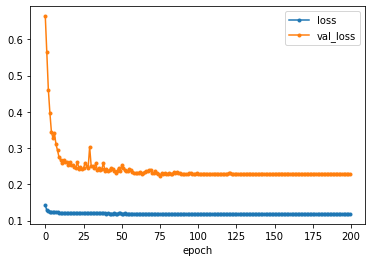

In [14]:
plot_history(history, ['loss', 'val_loss'])

## Computing Threshold Value
The network predicts 4 output channels:
1. The denoised input.
2. The background likelihoods.
3. The foreground likelihoods.
4. The border likelihoods.

We will threshold the foreground prediction image to obtain object segmentations. The optimal threshold is determined on the validation data. Additionally we can optimize the threshold for a given measure. In this case we choose the Average Precision (AP) measure.

In [15]:
threshold, val_score = model.optimize_thresholds(val_images.astype(np.float32), val_masks, measure=measure_precision())

print("The higest score of {} is achieved with threshold = {}.".format(np.round(val_score, 3), threshold))

Computing best threshold: 


/home/tbuchhol/Gitrepos/DenoiSeg/denoiseg/utils/compute_precision_threshold.py:7: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "pixel_sharing_bipartite" failed type inference due to: Invalid use of Function(<built-in function zeros>) with argument(s) of type(s): (UniTuple(int64 x 2), dtype=Function(<class 'int'>))
 * parameterized
In definition 0:
    All templates rejected with literals.
In definition 1:
    All templates rejected without literals.
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<built-in function zeros>)
[2] During: typing of call at /home/tbuchhol/Gitrepos/DenoiSeg/denoiseg/utils/compute_precision_threshold.py (10)


File "../../denoiseg/utils/compute_precision_threshold.py", line 10:
def pixel_sharing_bipartite(lab1, lab2):
    <source elided>
    assert lab1.shape == lab2.shape
    psg = np.zeros((lab1.max() + 

Score for threshold = 0.10 is 0.7025
Score for threshold = 0.15 is 0.7220
Score for threshold = 0.20 is 0.7284
Score for threshold = 0.25 is 0.7307
Score for threshold = 0.30 is 0.7268
Score for threshold = 0.35 is 0.7283
Score for threshold = 0.40 is 0.7239
Score for threshold = 0.45 is 0.7134
Score for threshold = 0.50 is 0.7034
Score for threshold = 0.55 is 0.6979
Score for threshold = 0.60 is 0.6846
Score for threshold = 0.65 is 0.6708
Score for threshold = 0.70 is 0.6466
Score for threshold = 0.75 is 0.6153
Score for threshold = 0.80 is 0.5734
Score for threshold = 0.85 is 0.5134
Score for threshold = 0.90 is 0.4337
Score for threshold = 0.95 is 0.3205
Score for threshold = 1.00 is 0.0000

The higest score of 0.731 is achieved with threshold = 0.25.


## Test Data
Finally we load the test data and run the prediction.

In [16]:
test_data =  np.load('data/DSB2018_{}/test/test_data.npz'.format(noise_level), allow_pickle=True)
test_images = test_data['X_test']
test_masks = test_data['Y_test']

In [17]:
predicted_images, precision_result = model.predict_label_masks(test_images, test_masks, threshold, 
                                                                   measure=measure_precision())
print("Average precision over all test images with threshold = {} is {}.".format(threshold, np.round(precision_result, 3)))

Average precision over all test images with threshold = 0.25 is 0.694.
